# Building X_train, X_test and y_train, y_test datasets

# Train an MLP, and run inference on testing data
### This is the continuation of `cloud_01_getAllData.ipynb` noteobok

After learning how to retrieve data from around the wells, we can start with the machine learning portion of the workflow. We have reduced the section that is still necessary from the previous notebook into a single cell. If you need to review that code please go to the `cloud_01_getAllData.ipynb` notebook. 

**In this notebook we will cover the following:**

0. Data Ingestion and Filtering (Extract seismic at wellbore)
1. Feature Engineering
2. Data Preparation for ML Model Training
3. Neural Network Model Training
4. Bootstrap Aggregation and Inference
5. Conclusions

**This notebook assumes your AWS Credentials have been configured correctly**

# <font color='red'>This code used for final results creating </font>

In [2]:
# %%capture
# %pip install s3fs==0.5.0
# %pip install real-simple-seismic

In [3]:
from math import floor, ceil

from rss.client import rssFromS3
from pandas import concat, IndexSlice, read_csv, read_json

In [4]:
!pwd

/data/GSH_2021_competition/geoml_competitions/seismic_inversion_2021/tutorials


In [5]:

import pickle
## read back
file_name="training_wells.pikl"
file=open(file_name,"rb")
wells=pickle.load(file)
file.close()
wells
## read back
file_name="training_well_seismic.pikl"
file=open(file_name,"rb")
well_seismic=pickle.load(file)
file.close()
well_seismic

## read back
file_name="training_horizons.pikl"
file=open(file_name,"rb")
horizons=pickle.load(file)
file.close()
horizons

water_bottom  top_heywood  top_johnson  top_jameison  \
inline xline                                                         
1080   1080          581.9       2058.3       2346.8        2719.2   
       1081          581.8       2058.3       2346.8        2719.3   
       1082          581.8       2058.4       2347.1        2719.5   
       1083          581.8       2058.4       2347.3        2719.7   
       1084          581.8       2058.4       2347.6        2720.0   
...                    ...          ...          ...           ...   
3700   3196          648.1       2062.7       2493.0        2633.7   
       3197          648.2       2062.7       2493.0        2633.7   
       3198          648.2       2062.7       2492.9        2633.6   
       3199          648.2       2062.7       2492.9        2633.6   
       3200          648.2       2062.7       2492.9        2633.6   

              top_near_plover  
inline xline                   
1080   1080            3327.9  
       1081            3327.8  
       1082            3327.8  
       1083            3327.8  
       1084            3327.7  
...                       ...  
3700   3196            3985.7  
       3197            3985.1  
       3198            3984.5  
       3199            3983.9  
       3200            3983.3  

[5559141 rows x 5 columns]

In [6]:
# !pip install seaborn
# !pip install sklearn

# Section 0. Data Ingestion and Filtering
### This section below is the same as in `cloud_01_getAllData.ipynb`
If you need to review the code please visit this notebook under tutorial section of the competition GitHub

# Section 1. Feature Engineering

Let's begin with loading some libraries

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler
sns.set(style="darkgrid")

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras as k

In [8]:
import numpy as np

In this quick tutorial, we will extract **only** the near stack data for each well and save into independent variables. In the real application, we recommend you use near, mid, far stacks and velocity cubes as independent features. The rock properties we are predicting are physically related to differences between near, mid, and far stacks.

In [9]:
from sys import getsizeof
len(well_seismic)

6

In [10]:
#!pip install pickle-mixin

import pickle
import pandas as pd
import numpy as np
slicer = pd.IndexSlice

## read back
file_name="well_df.pikl"
file=open(file_name,"rb")
well_df=pickle.load(file)
file.close()
#wellsn

## read back
file_name="well_sub_df.pikl"
file=open(file_name,"rb")
well_sub_df=pickle.load(file)
file.close()
#well_sub_df

## read back
file_name="well_seismic.pikl"
file=open(file_name,"rb")
well_seismic=pickle.load(file)
file.close()
#well_seismic_veln

## read back
file_name="well_sub_seismic.pikl"
file=open(file_name,"rb")
well_sub_seismic=pickle.load(file)
file.close()
#well_seismic_veln

## read back
file_name="training_horizons.pikl"
file=open(file_name,"rb")
horizons=pickle.load(file)
file.close()
#horizons

In [11]:
well_sub_df

inline      xline  rhob  p_impedance  s_impedance
well_id twt                                                         
well_07 2700.0  3256.5233  1389.3571   NaN          NaN          NaN
        2700.5  3256.5234  1389.3559   NaN          NaN          NaN
        2701.0  3256.5236  1389.3547   NaN          NaN          NaN
        2701.5  3256.5237  1389.3535   NaN          NaN          NaN
        2702.0  3256.5238  1389.3523   NaN          NaN          NaN
...                   ...        ...   ...          ...          ...
well_13 3383.5  2407.1952  2675.8771   NaN          NaN          NaN
        3384.0  2407.1905  2675.8925   NaN          NaN          NaN
        3384.5  2407.1858  2675.9078   NaN          NaN          NaN
        3385.0  2407.1811  2675.9232   NaN          NaN          NaN
        3385.5  2407.1763  2675.9386   NaN          NaN          NaN

[1773 rows x 5 columns]

In [12]:
well_sub_df_sel=well_sub_df[['inline','xline']]
well_df_Sel=well_df[['inline','xline']]
well_df_all= pd.concat([well_df_Sel,well_sub_df_sel],axis=0)
#well_df_all.set_index('well_id')
well_df_all = well_df_all.sort_index()
well_df_all

inline      xline
well_id twt                         
well_01 1136.5  2992.8834  2202.6259
        1137.0  2992.8834  2202.6259
        1137.5  2992.8834  2202.6258
        1138.0  2992.8834  2202.6258
        1138.5  2992.8834  2202.6258
...                   ...        ...
well_33 3275.5  3184.5065  2347.5496
        3276.0  3184.5094  2347.5584
        3276.5  3184.5122  2347.5671
        3277.0  3184.5150  2347.5758
        3277.5  3184.5178  2347.5846

[16597 rows x 2 columns]

In [13]:
logs = well_df_all.reset_index()

in_x = {}

for i in ['well_01', 'well_07', 'well_11', 'well_13', 'well_21', 'well_25', 'well_27', 'well_33']:
    well = logs[logs['well_id'] == i ]
    well[['inline','xline']] = well[['inline','xline']].round(0)
    xline = np.sort(well['xline'].unique())
    inline = np.sort(well['inline'].unique())
    in_x[i] = inline,xline

pd.set_option('max_colwidth',300)
pd.DataFrame.from_dict(in_x,orient='index',columns=['inline','xline']) 

w1h = {}
h1 = horizons.loc[slicer[2993, 2202.0:2209.0], :]
for i in h1.keys():
    w1h[i] = np.round(h1[i].mean(),0)
    
w2h = {}
h2 = horizons.loc[slicer[3257.0, 1389.0:1390.0], :]
for i in h2.keys():
    w2h[i] = np.round(h2[i].mean(),0)
    
h3 = horizons.loc[slicer[3524.0, 2397.0:2400.0], :]
w3h = {}
for i in h3.keys():
    w3h[i] = np.round(h3[i].mean(),0)   
    
h4 = horizons.loc[slicer[2407.0:2408.0, 2671.0:2676.0], :]
w4h = {}
for i in h4.keys():
    w4h[i] = np.round(h4[i].mean(),0) 
    
h5 = horizons.loc[slicer[2766.0:2770.0, 1491.0:1493.0], :]
w5h = {}
for i in h5.keys():
    w5h[i] = np.round(h5[i].mean(),0)    
    
h6 = horizons.loc[slicer[1193.0:1195.0, 2513.0:2518.0], :]
w6h = {}
for i in h6.keys():
    w6h[i] = np.round(h6[i].mean(),0)    
    
w7h = {}
h7 = horizons.loc[slicer[2856.0:2858.0, 2285.0:2290.0], :]
for i in h7.keys():
    w7h[i] = np.round(h7[i].mean(),0) 
    
w8h = {}
h8 = horizons.loc[slicer[3179.0:3184.0, 2337.0:2348.0], :]
for i in h8.keys():
    w8h[i] = np.round(h8[i].mean(),0)    

/home/dongjie/venvs/tensorflow/lib64/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
def define_horizon(data,well,horizon):
    
    wells = ['well_01', 'well_11', 'well_21', 'well_25', 'well_27', 'well_33']
    id =  wells[well-1]
      
    tops = list(horizon.values())
    
    for i in range(len(tops)):
        if i != (len(tops)-1):
            data.loc[slicer[id,tops[i]:tops[i+1]], 'horizon'] = i+1
        else:
            data.loc[slicer[id,tops[i]:], 'horizon'] = i+1
    
    return data

tops = [w1h, w3h, w5h, w6h, w7h, w8h]

for i in range(len(tops)):    
    well_df_1 = define_horizon(well_df,i+1,tops[i])

well_df_1

tvdss     inline      xline    gamma   rshal    rdeep  \
well_id twt                                                                 
well_01 1136.5  2798.4675  2992.8834  2202.6259   8.6726  3.7827   2.2789   
        1137.0  2798.4723  2992.8834  2202.6259   8.6323  3.7982   2.2860   
        1137.5  2798.4771  2992.8834  2202.6258   8.5921  3.8136   2.2931   
        1138.0  2798.4819  2992.8834  2202.6258   8.5518  3.8290   2.3002   
        1138.5  2798.4867  2992.8834  2202.6258   8.5115  3.8445   2.3073   
...                   ...        ...        ...      ...     ...      ...   
well_33 3275.5  4930.9019  3184.5065  2347.5496  25.9762     NaN   1.2904   
        3276.0  4931.7274  3184.5094  2347.5584  32.2211     NaN   0.3794   
        3276.5  4932.5529  3184.5122  2347.5671  24.3830     NaN   0.6208   
        3277.0  4933.3784  3184.5150  2347.5758  32.3072     NaN   7.0806   
        3277.5  4934.2090  3184.5178  2347.5846  44.1339     NaN  17.5096   

                  nphi     cal    rhob      dtc       dts  horizon  
well_id twt                                                         
well_01 1136.5     NaN     NaN     NaN  58.3867       NaN      1.0  
        1137.0     NaN     NaN     NaN  58.4215       NaN      1.0  
        1137.5     NaN     NaN     NaN  58.4564       NaN      1.0  
        1138.0     NaN     NaN     NaN  58.4912       NaN      1.0  
        1138.5     NaN     NaN     NaN  58.5260       NaN      1.0  
...                ...     ...     ...      ...       ...      ...  
well_33 3275.5  3.9099  5.8378  2.5694  67.4372  104.0350      5.0  
        3276.0  3.5481  5.8382  2.5828  72.2925  109.3575      5.0  
        3276.5  2.5321  5.8363  2.4341  68.8159  104.5286      5.0  
        3277.0  3.0198  5.8567  2.3997  71.4051  105.4713      5.0  
        3277.5  5.1812  5.8652  2.4335      NaN       NaN      5.0  

[14824 rows x 12 columns]

In [15]:
def define_horizon_2(data2,well,horizon):
    
    wells = ['well_07', 'well_13']
    id =  wells[well-1]
      
    tops = list(horizon.values())
    
    for i in range(len(tops)):
        if i != (len(tops)-1):
            data2.loc[slicer[id,tops[i]:tops[i+1]], 'horizon'] = i+1
        else:
            data2.loc[slicer[id,tops[i]:], 'horizon'] = i+1
    
    return data2

tops = [w2h, w4h]

for i in range(len(tops)):    
    well_sub_df_1 = define_horizon_2(well_sub_df,i+1,tops[i])

well_sub_df_1

inline      xline  rhob  p_impedance  s_impedance  horizon
well_id twt                                                                  
well_07 2700.0  3256.5233  1389.3571   NaN          NaN          NaN      4.0
        2700.5  3256.5234  1389.3559   NaN          NaN          NaN      4.0
        2701.0  3256.5236  1389.3547   NaN          NaN          NaN      4.0
        2701.5  3256.5237  1389.3535   NaN          NaN          NaN      4.0
        2702.0  3256.5238  1389.3523   NaN          NaN          NaN      4.0
...                   ...        ...   ...          ...          ...      ...
well_13 3383.5  2407.1952  2675.8771   NaN          NaN          NaN      5.0
        3384.0  2407.1905  2675.8925   NaN          NaN          NaN      5.0
        3384.5  2407.1858  2675.9078   NaN          NaN          NaN      5.0
        3385.0  2407.1811  2675.9232   NaN          NaN          NaN      5.0
        3385.5  2407.1763  2675.9386   NaN          NaN          NaN      5.0

[1773 rows x 6 columns]

In [16]:
well_df_1

tvdss     inline      xline    gamma   rshal    rdeep  \
well_id twt                                                                 
well_01 1136.5  2798.4675  2992.8834  2202.6259   8.6726  3.7827   2.2789   
        1137.0  2798.4723  2992.8834  2202.6259   8.6323  3.7982   2.2860   
        1137.5  2798.4771  2992.8834  2202.6258   8.5921  3.8136   2.2931   
        1138.0  2798.4819  2992.8834  2202.6258   8.5518  3.8290   2.3002   
        1138.5  2798.4867  2992.8834  2202.6258   8.5115  3.8445   2.3073   
...                   ...        ...        ...      ...     ...      ...   
well_33 3275.5  4930.9019  3184.5065  2347.5496  25.9762     NaN   1.2904   
        3276.0  4931.7274  3184.5094  2347.5584  32.2211     NaN   0.3794   
        3276.5  4932.5529  3184.5122  2347.5671  24.3830     NaN   0.6208   
        3277.0  4933.3784  3184.5150  2347.5758  32.3072     NaN   7.0806   
        3277.5  4934.2090  3184.5178  2347.5846  44.1339     NaN  17.5096   

                  nphi     cal    rhob      dtc       dts  horizon  
well_id twt                                                         
well_01 1136.5     NaN     NaN     NaN  58.3867       NaN      1.0  
        1137.0     NaN     NaN     NaN  58.4215       NaN      1.0  
        1137.5     NaN     NaN     NaN  58.4564       NaN      1.0  
        1138.0     NaN     NaN     NaN  58.4912       NaN      1.0  
        1138.5     NaN     NaN     NaN  58.5260       NaN      1.0  
...                ...     ...     ...      ...       ...      ...  
well_33 3275.5  3.9099  5.8378  2.5694  67.4372  104.0350      5.0  
        3276.0  3.5481  5.8382  2.5828  72.2925  109.3575      5.0  
        3276.5  2.5321  5.8363  2.4341  68.8159  104.5286      5.0  
        3277.0  3.0198  5.8567  2.3997  71.4051  105.4713      5.0  
        3277.5  5.1812  5.8652  2.4335      NaN       NaN      5.0  

[14824 rows x 12 columns]

In [17]:
ld_training_well_hor=well_df_1.copy()
ld_input_well_hor=well_sub_df_1.copy()

In [18]:
# added late for velocity only

file_name="well_seismic.pikl"

file=open(file_name,"rb")
wellsn=pickle.load(file)
file.close()
# wellsn['well_01']['velocity']

In [19]:
vel_01=wellsn['well_01']['velocity']/0.3048
vel_11=wellsn['well_11']['velocity']/0.3048
vel_21=wellsn['well_21']['velocity']/0.3048
vel_25=wellsn['well_25']['velocity']/0.3048
vel_27=wellsn['well_27']['velocity']/0.3048
vel_33=wellsn['well_33']['velocity']/0.3048

In [20]:
near_01 = well_seismic['well_01']['near']
near_11 = well_seismic['well_11']['near']
near_21 = well_seismic['well_21']['near']
near_25 = well_seismic['well_25']['near']
near_27 = well_seismic['well_27']['near']
near_33 = well_seismic['well_33']['near']

In [21]:
#near_01.shape
# well_seismic

In [22]:
mid_01 = well_seismic['well_01']['mid']
mid_11 = well_seismic['well_11']['mid']
mid_21 = well_seismic['well_21']['mid']
mid_25 = well_seismic['well_25']['mid']
mid_27 = well_seismic['well_27']['mid']
mid_33 = well_seismic['well_33']['mid']

In [23]:
far_01 = well_seismic['well_01']['far']
far_11 = well_seismic['well_11']['far']
far_21 = well_seismic['well_21']['far']
far_25 = well_seismic['well_25']['far']
far_27 = well_seismic['well_27']['far']
far_33 = well_seismic['well_33']['far']

Now we will average all of the traces into one array. Let's stick these in a list for later processing. 

*This is not the ideal way to do this but it is the quickest and simplest way to generate a composite (i.e. wellbore extracted) trace. We recommend you do a weighted average around exact wellbore coordinates or interpolate values TO the wellbore coordinates. When wells are deviated, the averaging we are doing here is quite strong, we don't want to mix too many irrelevant data.*

In [24]:
# Near: Average all IL/XL into a single array and create pd dataframes 
near_01_composite = pd.DataFrame(np.mean((np.mean(near_01,axis=1)), axis=0), columns=['near_01_composite'])
near_11_composite = pd.DataFrame(np.mean((np.mean(near_11,axis=1)), axis=0), columns=['near_11_composite'])
near_21_composite = pd.DataFrame(np.mean((np.mean(near_21,axis=1)), axis=0), columns=['near_21_composite'])
near_25_composite = pd.DataFrame(np.mean((np.mean(near_25,axis=1)), axis=0), columns=['near_25_composite'])
near_27_composite = pd.DataFrame(np.mean((np.mean(near_27,axis=1)), axis=0), columns=['near_27_composite'])
near_33_composite = pd.DataFrame(np.mean((np.mean(near_33,axis=1)), axis=0), columns=['near_33_composite'])

# Save into a list
near_composite_data = [near_01_composite, near_11_composite, near_21_composite, near_25_composite, near_27_composite, near_33_composite]

In [25]:
# Mid: Average all IL/XL into a single array and create pd dataframes 
mid_01_composite = pd.DataFrame(np.mean((np.mean(mid_01,axis=1)), axis=0), columns=['mid_01_composite'])
mid_11_composite = pd.DataFrame(np.mean((np.mean(mid_11,axis=1)), axis=0), columns=['mid_11_composite'])
mid_21_composite = pd.DataFrame(np.mean((np.mean(mid_21,axis=1)), axis=0), columns=['mid_21_composite'])
mid_25_composite = pd.DataFrame(np.mean((np.mean(mid_25,axis=1)), axis=0), columns=['mid_25_composite'])
mid_27_composite = pd.DataFrame(np.mean((np.mean(mid_27,axis=1)), axis=0), columns=['mid_27_composite'])
mid_33_composite = pd.DataFrame(np.mean((np.mean(mid_33,axis=1)), axis=0), columns=['mid_33_composite'])

# Save into a list
mid_composite_data = [mid_01_composite, mid_11_composite, mid_21_composite, mid_25_composite, mid_27_composite, mid_33_composite]

In [26]:
# Far: Average all IL/XL into a single array and create pd dataframes 
far_01_composite = pd.DataFrame(np.mean((np.mean(far_01,axis=1)), axis=0), columns=['far_01_composite'])
far_11_composite = pd.DataFrame(np.mean((np.mean(far_11,axis=1)), axis=0), columns=['far_11_composite'])
far_21_composite = pd.DataFrame(np.mean((np.mean(far_21,axis=1)), axis=0), columns=['far_21_composite'])
far_25_composite = pd.DataFrame(np.mean((np.mean(far_25,axis=1)), axis=0), columns=['far_25_composite'])
far_27_composite = pd.DataFrame(np.mean((np.mean(far_27,axis=1)), axis=0), columns=['far_27_composite'])
far_33_composite = pd.DataFrame(np.mean((np.mean(far_33,axis=1)), axis=0), columns=['far_33_composite'])

# Save into a list
far_composite_data = [far_01_composite, far_11_composite, far_21_composite, far_25_composite, far_27_composite, far_33_composite]

In [27]:
# vel: Average all IL/XL into a single array and create pd dataframes 
vel_01_composite = pd.DataFrame(np.mean((np.mean(vel_01,axis=1)), axis=0), columns=['vel_01_composite'])
vel_11_composite = pd.DataFrame(np.mean((np.mean(vel_11,axis=1)), axis=0), columns=['vel_11_composite'])
vel_21_composite = pd.DataFrame(np.mean((np.mean(vel_21,axis=1)), axis=0), columns=['vel_21_composite'])
vel_25_composite = pd.DataFrame(np.mean((np.mean(vel_25,axis=1)), axis=0), columns=['vel_25_composite'])
vel_27_composite = pd.DataFrame(np.mean((np.mean(vel_27,axis=1)), axis=0), columns=['vel_27_composite'])
vel_33_composite = pd.DataFrame(np.mean((np.mean(vel_33,axis=1)), axis=0), columns=['vel_33_composite'])
vel_composite_data = [vel_01_composite, vel_11_composite, vel_21_composite, vel_25_composite, vel_27_composite, vel_33_composite]

Let's plot all of the composites for a quick QC 

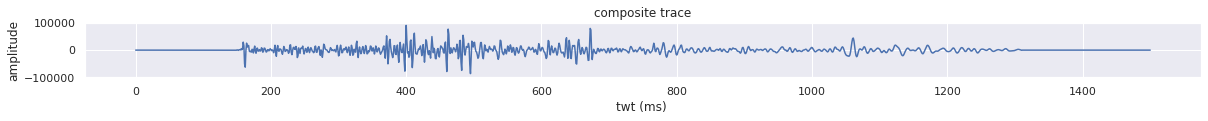

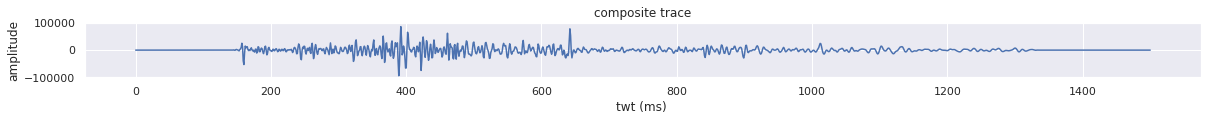

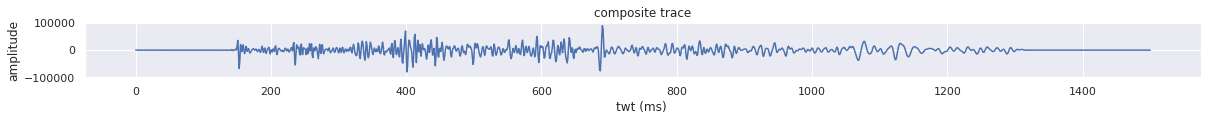

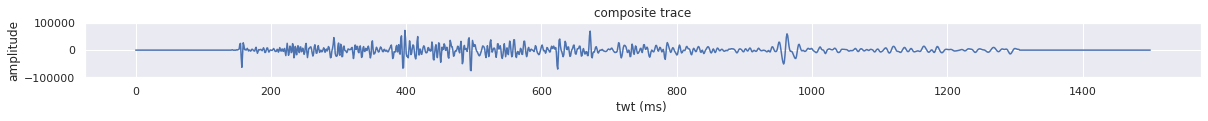

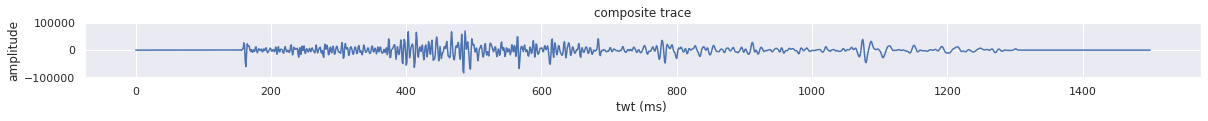

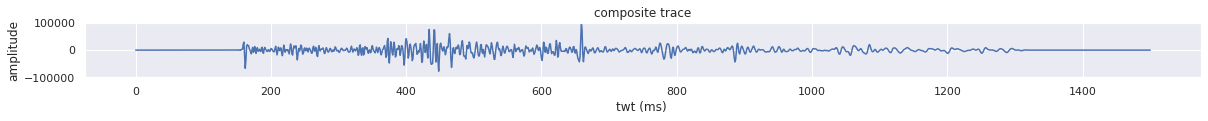

In [28]:
composite_data=[near_composite_data, mid_composite_data, far_composite_data, vel_composite_data ]
for composite in near_composite_data:
    plt.figure(figsize=(20,1))
    plt.plot(composite)
    plt.title('composite trace')
    plt.ylim(-100000,100000)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

In [29]:
# pd.concat(pd.DataFrame_from_list(composite_data), axis=1)
# composite_data

Create the two-way-time indices for the training DataFrame.

We will interpolate seismic traces using `cubic` interpolation to the same sample rate as the well data, which is every 0.5 ms two-way-time.

If you recall:

*Poseidon data vertical sampling is between 0 and 6,000 milliseconds.*

*Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.*


In [30]:
# index at 4ms 
seismic_twt = pd.DataFrame(np.arange(0, 6004.0, 4.0), columns=['twt'])

# index at .5 ms 
resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])

In [31]:
# Near DataFrames to concatenate 
data_concat = [seismic_twt, near_01_composite, near_11_composite, near_21_composite, near_25_composite, near_27_composite, near_33_composite]
tt_seismic = pd.concat(data_concat, axis=1)

# Here we merge our seismic to the resamp 'twt' array
near_data_concat_resamp_raw = tt_seismic.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
near_data_concat_resamp_interp = near_data_concat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
near_data_concat_resamp_interp

,twt,near_01_composite,near_11_composite,near_21_composite,near_25_composite,near_27_composite,near_33_composite
0,0.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
1,0.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
2,1.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
3,1.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
4,2.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
...,...,...,...,...,...,...,...
11996,5998.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
11997,5998.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
11998,5999.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
11999,5999.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084


In [32]:
# Mid DataFrames to concatenate 
data_concat = [seismic_twt, mid_01_composite, mid_11_composite, mid_21_composite, mid_25_composite, mid_27_composite, mid_33_composite]
tt_seismic = pd.concat(data_concat, axis=1)

# Here we merge our seismic to the resamp 'twt' array
mid_data_concat_resamp_raw = tt_seismic.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
mid_data_concat_resamp_interp = mid_data_concat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
mid_data_concat_resamp_interp

,twt,mid_01_composite,mid_11_composite,mid_21_composite,mid_25_composite,mid_27_composite,mid_33_composite
0,0.0,-2.177104,-3.05652,-1.519445,-2.399689,-1.749989,-1.144555
1,0.5,-2.177104,-3.05652,-1.519445,-2.399689,-1.749989,-1.144555
2,1.0,-2.177104,-3.05652,-1.519445,-2.399689,-1.749989,-1.144555
3,1.5,-2.177104,-3.05652,-1.519445,-2.399689,-1.749989,-1.144555
4,2.0,-2.177104,-3.05652,-1.519445,-2.399689,-1.749989,-1.144555
...,...,...,...,...,...,...,...
11996,5998.0,-2.177104,-3.05652,-1.519445,-2.399689,-1.749989,-1.144555
11997,5998.5,-2.177104,-3.05652,-1.519445,-2.399689,-1.749989,-1.144555
11998,5999.0,-2.177104,-3.05652,-1.519445,-2.399689,-1.749989,-1.144555
11999,5999.5,-2.177104,-3.05652,-1.519445,-2.399689,-1.749989,-1.144555


In [33]:
# Far DataFrames to concatenate 
data_concat = [seismic_twt, far_01_composite, far_11_composite, far_21_composite, far_25_composite, far_27_composite, far_33_composite]
tt_seismic = pd.concat(data_concat, axis=1)

# Here we merge our seismic to the resamp 'twt' array
far_data_concat_resamp_raw = tt_seismic.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
far_data_concat_resamp_interp = far_data_concat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
far_data_concat_resamp_interp

,twt,far_01_composite,far_11_composite,far_21_composite,far_25_composite,far_27_composite,far_33_composite
0,0.0,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823
1,0.5,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823
2,1.0,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823
3,1.5,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823
4,2.0,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823
...,...,...,...,...,...,...,...
11996,5998.0,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823
11997,5998.5,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823
11998,5999.0,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823
11999,5999.5,-1.195044,-1.788095,-1.54652,-1.273305,-0.613544,-1.94823


# velocity interpolation

In [34]:
# vel index at 10ms 
vel_twt = pd.DataFrame(np.arange(0, 6010.0, 10.0), columns=['twt'])

# index at .5 ms 
vel_resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])

In [35]:
# vel DataFrames to concatenate 
velconcat = [vel_twt, vel_01_composite, vel_11_composite, vel_21_composite, vel_25_composite, vel_27_composite, vel_33_composite]
tt_vel = pd.concat(velconcat, axis=1)

# Here we merge our vel to the resamp 'twt' array
vel_velconcat_resamp_raw = tt_vel.merge(vel_resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the vel after the resamp
vel_velconcat_resamp_interp = vel_velconcat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
vel_velconcat_resamp_interp

,twt,vel_01_composite,vel_11_composite,vel_21_composite,vel_25_composite,vel_27_composite,vel_33_composite
0,0.0,4998.261873,4998.203884,4998.241456,4998.235298,4998.185961,4998.219403
1,0.5,4998.262881,4998.204739,4998.242381,4998.236218,4998.186814,4998.220261
2,1.0,4998.263734,4998.205463,4998.243164,4998.236997,4998.187536,4998.220987
3,1.5,4998.264439,4998.206062,4998.243812,4998.237641,4998.188133,4998.221588
4,2.0,4998.265007,4998.206544,4998.244332,4998.238159,4998.188613,4998.222071
...,...,...,...,...,...,...,...
11996,5998.0,17150.064270,17475.439490,17022.683138,16746.783604,17147.772612,17326.917935
11997,5998.5,17150.071639,17475.440660,17022.688654,16746.791352,17147.763822,17326.925554
11998,5999.0,17150.080228,17475.442332,17022.695169,16746.800750,17147.754108,17326.934526
11999,5999.5,17150.090087,17475.444533,17022.702727,16746.811878,17147.743434,17326.944917


In [36]:
vels_velconcat_resamp_interp=vel_velconcat_resamp_interp.copy()
vels_velconcat_resamp_interp=(vels_velconcat_resamp_interp)/1.44
vels_velconcat_resamp_interp['twt']=vels_velconcat_resamp_interp['twt']*1.44
vels_velconcat_resamp_interp

,twt,vel_01_composite,vel_11_composite,vel_21_composite,vel_25_composite,vel_27_composite,vel_33_composite
0,0.0,3471.015190,3470.974919,3471.001011,3470.996735,3470.962473,3470.985697
1,0.5,3471.015890,3470.975513,3471.001654,3470.997374,3470.963065,3470.986293
2,1.0,3471.016482,3470.976016,3471.002197,3470.997914,3470.963566,3470.986797
3,1.5,3471.016972,3470.976432,3471.002647,3470.998362,3470.963981,3470.987214
4,2.0,3471.017366,3470.976767,3471.003009,3470.998722,3470.964315,3470.987550
...,...,...,...,...,...,...,...
11996,5998.0,11909.766854,12135.721868,11821.307735,11629.710836,11908.175425,12032.581899
11997,5998.5,11909.771971,12135.722680,11821.311565,11629.716217,11908.169321,12032.587190
11998,5999.0,11909.777936,12135.723842,11821.316089,11629.722743,11908.162575,12032.593421
11999,5999.5,11909.784782,12135.725370,11821.321338,11629.730471,11908.155163,12032.600637


In [37]:
vels_velconcat_resamp_interp.rename(columns={"vel_01_composite": "vels_01_composite",
                                             "vel_11_composite": "vels_11_composite",
                                             "vel_21_composite": "vels_21_composite",
                                             "vel_25_composite": "vels_25_composite",
                                             "vel_27_composite": "vels_27_composite",
                                             "vel_33_composite": "vels_33_composite"}, inplace=True)


Here we make a copy of wells to not corrupt the original dataframe.

In [38]:
near_01_composite_resamp = near_data_concat_resamp_interp[['twt','near_01_composite']].copy()
near_11_composite_resamp = near_data_concat_resamp_interp[['twt','near_11_composite']].copy()
near_21_composite_resamp = near_data_concat_resamp_interp[['twt','near_21_composite']].copy()
near_25_composite_resamp = near_data_concat_resamp_interp[['twt','near_25_composite']].copy()
near_27_composite_resamp = near_data_concat_resamp_interp[['twt','near_27_composite']].copy()
near_33_composite_resamp = near_data_concat_resamp_interp[['twt','near_33_composite']].copy()

In [39]:
mid_01_composite_resamp = mid_data_concat_resamp_interp[['twt','mid_01_composite']].copy()
mid_11_composite_resamp = mid_data_concat_resamp_interp[['twt','mid_11_composite']].copy()
mid_21_composite_resamp = mid_data_concat_resamp_interp[['twt','mid_21_composite']].copy()
mid_25_composite_resamp = mid_data_concat_resamp_interp[['twt','mid_25_composite']].copy()
mid_27_composite_resamp = mid_data_concat_resamp_interp[['twt','mid_27_composite']].copy()
mid_33_composite_resamp = mid_data_concat_resamp_interp[['twt','mid_33_composite']].copy()

In [40]:
far_01_composite_resamp = far_data_concat_resamp_interp[['twt','far_01_composite']].copy()
far_11_composite_resamp = far_data_concat_resamp_interp[['twt','far_11_composite']].copy()
far_21_composite_resamp = far_data_concat_resamp_interp[['twt','far_21_composite']].copy()
far_25_composite_resamp = far_data_concat_resamp_interp[['twt','far_25_composite']].copy()
far_27_composite_resamp = far_data_concat_resamp_interp[['twt','far_27_composite']].copy()
far_33_composite_resamp = far_data_concat_resamp_interp[['twt','far_33_composite']].copy()

In [41]:
vel_01_composite_resamp = vel_velconcat_resamp_interp[['twt','vel_01_composite']].copy()
vel_11_composite_resamp = vel_velconcat_resamp_interp[['twt','vel_11_composite']].copy()
vel_21_composite_resamp = vel_velconcat_resamp_interp[['twt','vel_21_composite']].copy()
vel_25_composite_resamp = vel_velconcat_resamp_interp[['twt','vel_25_composite']].copy()
vel_27_composite_resamp = vel_velconcat_resamp_interp[['twt','vel_27_composite']].copy()
vel_33_composite_resamp = vel_velconcat_resamp_interp[['twt','vel_33_composite']].copy()

In [42]:
vels_01_composite_resamp = vels_velconcat_resamp_interp[['twt','vels_01_composite']].copy()
vels_11_composite_resamp = vels_velconcat_resamp_interp[['twt','vels_11_composite']].copy()
vels_21_composite_resamp = vels_velconcat_resamp_interp[['twt','vels_21_composite']].copy()
vels_25_composite_resamp = vels_velconcat_resamp_interp[['twt','vels_25_composite']].copy()
vels_27_composite_resamp = vels_velconcat_resamp_interp[['twt','vels_27_composite']].copy()
vels_33_composite_resamp = vels_velconcat_resamp_interp[['twt','vels_33_composite']].copy()

In [43]:
vel_33_composite_resamp

,twt,vel_33_composite
0,0.0,4998.219403
1,0.5,4998.220261
2,1.0,4998.220987
3,1.5,4998.221588
4,2.0,4998.222071
...,...,...
11996,5998.0,17326.917935
11997,5998.5,17326.925554
11998,5999.0,17326.934526
11999,5999.5,17326.944917


## Merge different offsets for same well

In [44]:
# Well 01
data_concat = [near_01_composite_resamp,mid_01_composite_resamp,far_01_composite_resamp,
               vel_01_composite_resamp,vels_01_composite_resamp  ]
seismic_01 = pd.concat(data_concat, axis=1)
seismic_01 = seismic_01.loc[:,~seismic_01.columns.duplicated()]


In [45]:
# Well 11
data_concat = [near_11_composite_resamp,mid_11_composite_resamp,far_11_composite_resamp,
               vel_11_composite_resamp,vels_11_composite_resamp ]
seismic_11 = pd.concat(data_concat, axis=1)
seismic_11 = seismic_11.loc[:,~seismic_11.columns.duplicated()]

In [46]:
# Well 21
data_concat = [near_21_composite_resamp,mid_21_composite_resamp,far_21_composite_resamp,
               vel_21_composite_resamp,vels_21_composite_resamp ]
seismic_21 = pd.concat(data_concat, axis=1)
seismic_21 = seismic_21.loc[:,~seismic_21.columns.duplicated()]

In [47]:
# Well 25
data_concat = [near_25_composite_resamp,mid_25_composite_resamp,far_25_composite_resamp,
               vel_25_composite_resamp,vels_25_composite_resamp ]
seismic_25 = pd.concat(data_concat, axis=1)
seismic_25 = seismic_25.loc[:,~seismic_25.columns.duplicated()]

In [48]:
# Well 27
data_concat = [near_27_composite_resamp,mid_27_composite_resamp,far_27_composite_resamp,
               vel_27_composite_resamp,vels_27_composite_resamp ]
seismic_27 = pd.concat(data_concat, axis=1)
seismic_27 = seismic_27.loc[:,~seismic_27.columns.duplicated()]

In [49]:
# Well 33
data_concat = [near_33_composite_resamp,mid_33_composite_resamp,far_33_composite_resamp,
               vel_33_composite_resamp,vels_33_composite_resamp ]
seismic_33 = pd.concat(data_concat, axis=1)
seismic_33 = seismic_33.loc[:,~seismic_33.columns.duplicated()]
seismic_33

,twt,near_33_composite,mid_33_composite,far_33_composite,vel_33_composite,vels_33_composite
0,0.0,-1.578084,-1.144555,-1.94823,4998.219403,3470.985697
1,0.5,-1.578084,-1.144555,-1.94823,4998.220261,3470.986293
2,1.0,-1.578084,-1.144555,-1.94823,4998.220987,3470.986797
3,1.5,-1.578084,-1.144555,-1.94823,4998.221588,3470.987214
4,2.0,-1.578084,-1.144555,-1.94823,4998.222071,3470.987550
...,...,...,...,...,...,...
11996,5998.0,-1.578084,-1.144555,-1.94823,17326.917935,12032.581899
11997,5998.5,-1.578084,-1.144555,-1.94823,17326.925554,12032.587190
11998,5999.0,-1.578084,-1.144555,-1.94823,17326.934526,12032.593421
11999,5999.5,-1.578084,-1.144555,-1.94823,17326.944917,12032.600637


In [50]:
## read back well_df, because cloud problem
file_name="well_df.pikl"

file=open(file_name,"rb")
well_df=pickle.load(file)
file.close()
well_df

tvdss     inline      xline    gamma   rshal    rdeep  \
well_id twt                                                                 
well_01 1136.5  2798.4675  2992.8834  2202.6259   8.6726  3.7827   2.2789   
        1137.0  2798.4723  2992.8834  2202.6259   8.6323  3.7982   2.2860   
        1137.5  2798.4771  2992.8834  2202.6258   8.5921  3.8136   2.2931   
        1138.0  2798.4819  2992.8834  2202.6258   8.5518  3.8290   2.3002   
        1138.5  2798.4867  2992.8834  2202.6258   8.5115  3.8445   2.3073   
...                   ...        ...        ...      ...     ...      ...   
well_33 3275.5  4930.9019  3184.5065  2347.5496  25.9762     NaN   1.2904   
        3276.0  4931.7274  3184.5094  2347.5584  32.2211     NaN   0.3794   
        3276.5  4932.5529  3184.5122  2347.5671  24.3830     NaN   0.6208   
        3277.0  4933.3784  3184.5150  2347.5758  32.3072     NaN   7.0806   
        3277.5  4934.2090  3184.5178  2347.5846  44.1339     NaN  17.5096   

                  nphi     cal    rhob      dtc       dts  
well_id twt                                                
well_01 1136.5     NaN     NaN     NaN  58.3867       NaN  
        1137.0     NaN     NaN     NaN  58.4215       NaN  
        1137.5     NaN     NaN     NaN  58.4564       NaN  
        1138.0     NaN     NaN     NaN  58.4912       NaN  
        1138.5     NaN     NaN     NaN  58.5260       NaN  
...                ...     ...     ...      ...       ...  
well_33 3275.5  3.9099  5.8378  2.5694  67.4372  104.0350  
        3276.0  3.5481  5.8382  2.5828  72.2925  109.3575  
        3276.5  2.5321  5.8363  2.4341  68.8159  104.5286  
        3277.0  3.0198  5.8567  2.3997  71.4051  105.4713  
        3277.5  5.1812  5.8652  2.4335      NaN       NaN  

[14824 rows x 11 columns]

In [51]:
well_01 = well_df.loc['well_01'].reset_index()
well_11 = well_df.loc['well_11'].reset_index()
well_21 = well_df.loc['well_21'].reset_index()
well_25 = well_df.loc['well_25'].reset_index()
well_27 = well_df.loc['well_27'].reset_index()
well_33 = well_df.loc['well_33'].reset_index()

Add appropriate targets P-Impedance (here, called Zp) and S-Impedance (here, called Zs). 

In [52]:
# #calculate impedances and add to data 
# # well_01
# well_01['Zp'] = (1000000/well_01['dtc'])*well_01['rhob']*0.3048
# well_01['Zs'] = (1000000/well_01['dts'])*well_01['rhob']*0.3048
# # well_11
# well_11['Zp'] = (1000000/well_11['dtc'])*well_11['rhob']*0.3048
# well_11['Zs'] = (1000000/well_11['dts'])*well_11['rhob']*0.3048
# # well_21
# well_21['Zp'] = (1000000/well_21['dtc'])*well_21['rhob']*0.3048
# well_21['Zs'] = (1000000/well_21['dts'])*well_21['rhob']*0.3048
# # well_25
# well_25['Zp'] = (1000000/well_25['dtc'])*well_25['rhob']*0.3048
# well_25['Zs'] = (1000000/well_25['dts'])*well_25['rhob']*0.3048
# # well_27
# well_27['Zp'] = (1000000/well_27['dtc'])*well_27['rhob']*0.3048
# well_27['Zs'] = (1000000/well_27['dts'])*well_27['rhob']*0.3048
# # well_33
# well_33['Zp'] = (1000000/well_33['dtc'])*well_33['rhob']*0.3048
# well_33['Zs'] = (1000000/well_33['dts'])*well_33['rhob']*0.3048

In [53]:
#calculate impedances and add to data 
# well_01
well_01['Zp'] = (1000000/well_01['dtc'])*well_01['rhob']
well_01['Zs'] = (1000000/well_01['dts'])*well_01['rhob']
# well_11
well_11['Zp'] = (1000000/well_11['dtc'])*well_11['rhob']
well_11['Zs'] = (1000000/well_11['dts'])*well_11['rhob']
# well_21
well_21['Zp'] = (1000000/well_21['dtc'])*well_21['rhob']
well_21['Zs'] = (1000000/well_21['dts'])*well_21['rhob']
# well_25
well_25['Zp'] = (1000000/well_25['dtc'])*well_25['rhob']
well_25['Zs'] = (1000000/well_25['dts'])*well_25['rhob']
# well_27
well_27['Zp'] = (1000000/well_27['dtc'])*well_27['rhob']
well_27['Zs'] = (1000000/well_27['dts'])*well_27['rhob']
# well_33
well_33['Zp'] = (1000000/well_33['dtc'])*well_33['rhob']
well_33['Zs'] = (1000000/well_33['dts'])*well_33['rhob']

In [54]:
# Lets filter the well data and keep only the relevant columns
well_01_stripped = well_01[['twt','Zp','Zs','rhob']].copy()
well_11_stripped = well_11[['twt','Zp','Zs','rhob']].copy()
well_21_stripped = well_21[['twt','Zp','Zs','rhob']].copy()
well_25_stripped = well_25[['twt','Zp','Zs','rhob']].copy()
well_27_stripped = well_27[['twt','Zp','Zs','rhob']].copy()
well_33_stripped = well_33[['twt','Zp','Zs','rhob']].copy()

Now we need to merge these two on the twt column - this gives us the association in twt of the well data and the composite trace. This is were good well-ties plays the most important role. 

In [55]:
well_01_tt = well_01_stripped.merge(seismic_01, how='right', on=['twt'])
well_01_tt['well_name'] = ['well_01'] * len(well_01_tt)
#well_01_tt.set_index(['well_name','twt'], inplace=True)
well_01_tt.set_index(['well_name'], inplace=True)
well_01_tt.rename(columns={"near_01_composite": "near_trace","mid_01_composite": "mid_trace","far_01_composite": "far_trace",
                           "vel_01_composite": "vel_trace","vels_01_composite": "vels_trace"}, inplace=True)

well_11_tt = well_11_stripped.merge(seismic_11, how='right', on=['twt'])
well_11_tt['well_name'] = ['well_11'] * len(well_11_tt)
#well_11_tt.set_index(['well_name','twt'], inplace=True)
well_11_tt.set_index(['well_name'], inplace=True)
well_11_tt.rename(columns={"near_11_composite": "near_trace","mid_11_composite": "mid_trace",
                           "far_11_composite": "far_trace",
                          "vel_11_composite": "vel_trace","vels_11_composite": "vels_trace"}, inplace=True)

well_21_tt = well_21_stripped.merge(seismic_21, how='right', on=['twt'])
well_21_tt['well_name'] = ['well_21'] * len(well_21_tt)
well_21_tt.set_index(['well_name'], inplace=True)
#well_21_tt.set_index(['well_name','twt'], inplace=True)
well_21_tt.rename(columns={"near_21_composite": "near_trace","mid_21_composite": "mid_trace",
                           "far_21_composite": "far_trace","vel_21_composite": "vel_trace",
                           "vels_21_composite": "vels_trace"}, inplace=True)

well_25_tt = well_25_stripped.merge(seismic_25, how='right', on=['twt'])
well_25_tt['well_name'] = ['well_25'] * len(well_25_tt)
well_25_tt.set_index(['well_name'], inplace=True)
#well_25_tt.set_index(['well_name','twt'], inplace=True)
well_25_tt.rename(columns={"near_25_composite": "near_trace","mid_25_composite": "mid_trace",
                           "far_25_composite": "far_trace",
                           "vel_25_composite": "vel_trace",
                           "vels_25_composite": "vels_trace"}, inplace=True)

well_27_tt = well_27_stripped.merge(seismic_27, how='right', on=['twt'])
well_27_tt['well_name'] = ['well_27'] * len(well_27_tt)
well_27_tt.set_index(['well_name'], inplace=True)
#well_27_tt.set_index(['well_name','twt'], inplace=True)
well_27_tt.rename(columns={"near_27_composite": "near_trace","mid_27_composite": "mid_trace",
                           "far_27_composite": "far_trace",
                           "vel_27_composite": "vel_trace",
                           "vels_27_composite": "vels_trace"}, inplace=True)

well_33_tt = well_33_stripped.merge(seismic_33, how='right', on=['twt'])
well_33_tt['well_name'] = ['well_33'] * len(well_33_tt)
well_33_tt.set_index(['well_name'], inplace=True)
#well_33_tt.set_index(['well_name','twt'], inplace=True)
well_33_tt.rename(columns={"near_33_composite": "near_trace","mid_33_composite": "mid_trace",
                           "far_33_composite": "far_trace",
                           "vel_33_composite": "vel_trace",
                           "vels_33_composite": "vels_trace"}, inplace=True)

tt_independent_wells = [well_01_tt, well_11_tt, well_21_tt, well_25_tt, well_27_tt, well_33_tt]

In [56]:
well_33_tt

,twt,Zp,Zs,rhob,near_trace,mid_trace,far_trace,vel_trace,vels_trace
well_name,,,,,,,,,
well_33,0.0,NaN,NaN,NaN,-1.578084,-1.144555,-1.94823,4998.219403,3470.985697
well_33,0.5,NaN,NaN,NaN,-1.578084,-1.144555,-1.94823,4998.220261,3470.986293
well_33,1.0,NaN,NaN,NaN,-1.578084,-1.144555,-1.94823,4998.220987,3470.986797
well_33,1.5,NaN,NaN,NaN,-1.578084,-1.144555,-1.94823,4998.221588,3470.987214
well_33,2.0,NaN,NaN,NaN,-1.578084,-1.144555,-1.94823,4998.222071,3470.987550
...,...,...,...,...,...,...,...,...,...
well_33,5998.0,NaN,NaN,NaN,-1.578084,-1.144555,-1.94823,17326.917935,12032.581899
well_33,5998.5,NaN,NaN,NaN,-1.578084,-1.144555,-1.94823,17326.925554,12032.587190
well_33,5999.0,NaN,NaN,NaN,-1.578084,-1.144555,-1.94823,17326.934526,12032.593421


Let's take a look at what our data looks like right now. You will notice that we don't have much data for the shallow or deep sections. Most of our data is between 2500ms and 3500ms. Your final, evaluation will likely focus on this interval. 

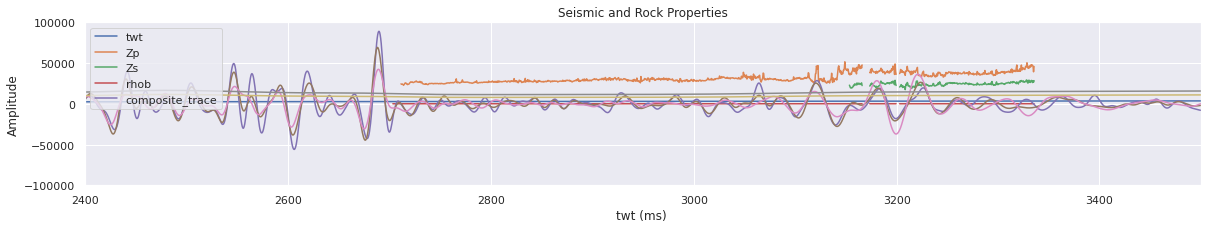

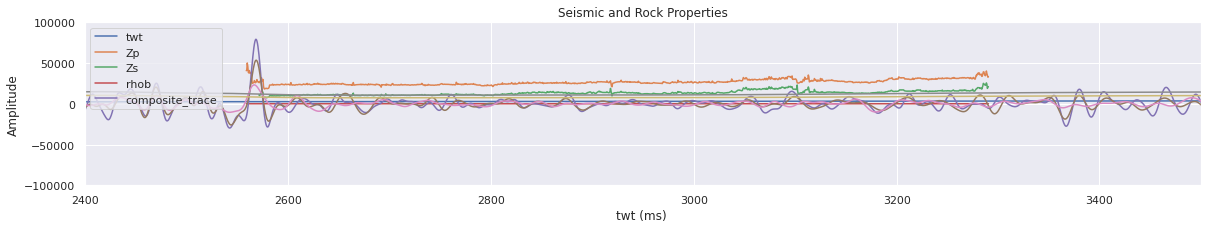

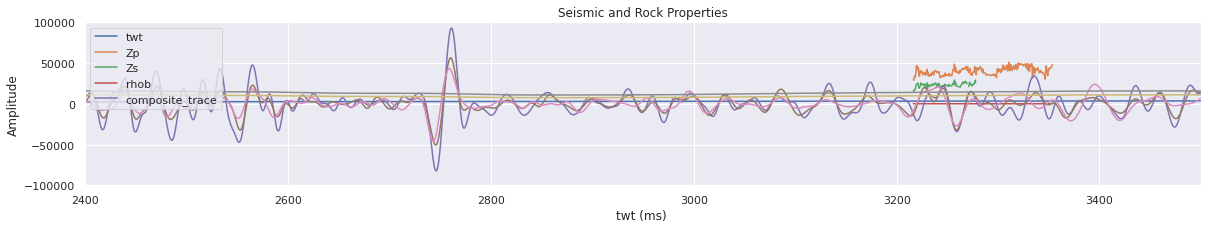

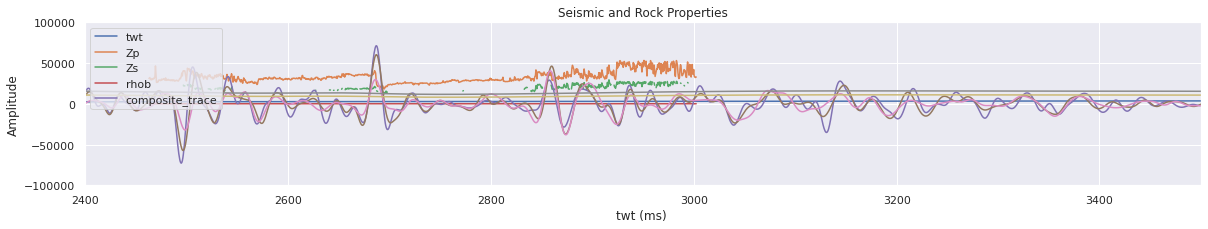

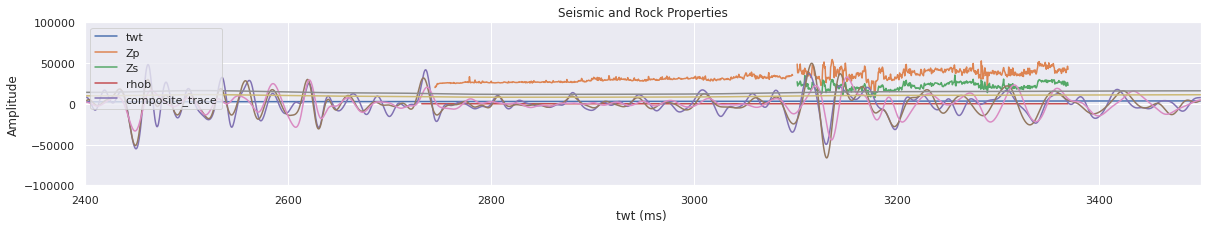

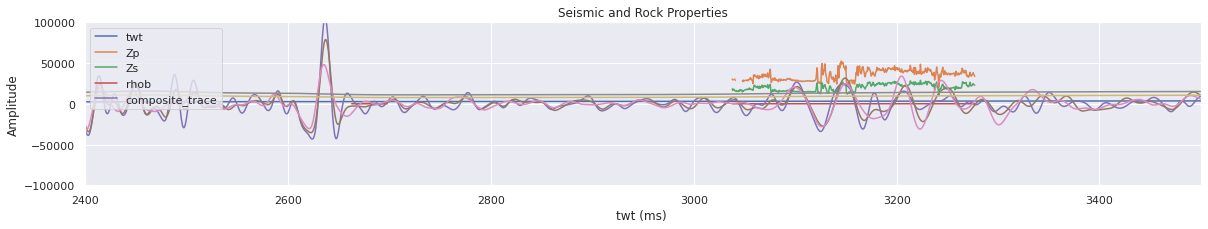

In [57]:
for tt_wells in tt_independent_wells:
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(0,6000.5,.5), tt_wells[:])
    plt.title('Seismic and Rock Properties')
    plt.ylim(-100000,100000)
    plt.xlim(2400,3500)
    plt.xlabel('twt (ms) ')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left', labels =['twt','Zp','Zs','rhob','composite_trace'])

Now let's play around with a few basic features that we can try to generate for training. Well start with a single well to illustrate an example and then we will loop through the rest of the wells to do it automatically. 

We will leave "twt" as a feature but you could consider developing another method for giving your models "depth" awareness. For instance, using horizons, or some other feature that is calculated from horizons and "twt" values.

#### Now let's drop all of the rows with NaNs

You are welcome to interpolate the small gaps or find other ways to interpolate


In [58]:
#drop rows with nans
well_01_tt_f = well_01_tt.dropna()

#Now, lets check out our finalized training table 
well_01_tt_f.head()

,twt,Zp,Zs,rhob,near_trace,mid_trace,far_trace,vel_trace,vels_trace
well_name,,,,,,,,,
well_01,3153.5,37061.358619,22785.667590,2.6977,-2001.303012,-1737.196090,-8189.487623,14152.541846,9828.154059
well_01,3154.0,35354.068894,21394.079211,2.6773,-1923.037918,-920.071803,-8042.105058,14157.835540,9831.830236
well_01,3154.5,35977.475724,19578.838348,2.6617,-1933.998110,-212.201430,-7928.684071,14163.082778,9835.474151
well_01,3155.0,37656.149932,19371.997677,2.6753,-2028.270606,383.499442,-7848.872507,14168.284935,9839.086761
well_01,3155.5,36089.365950,19873.146636,2.6642,-2199.942429,864.115225,-7802.318210,14173.443388,9842.669019


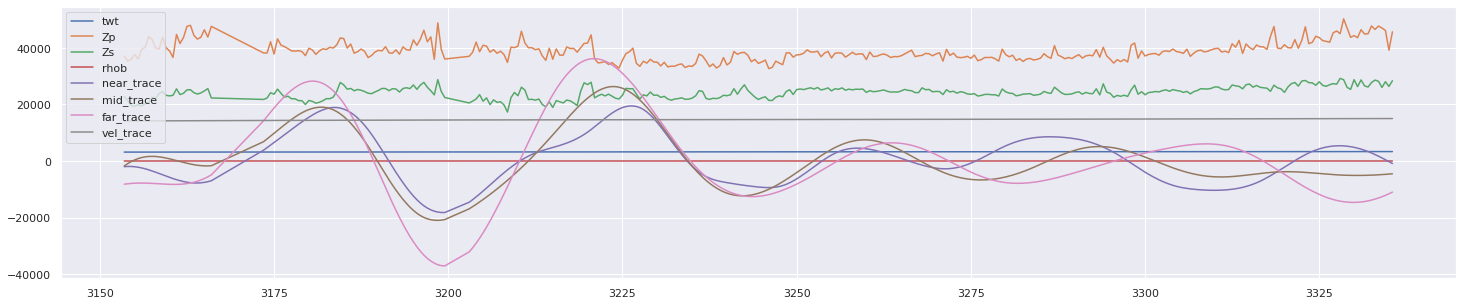

In [59]:
check = well_01_tt_f.reset_index()
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['twt', 
                              'Zp', 'Zs', 'rhob',
                               "near_trace", "mid_trace", "far_trace","vel_trace"]])

plt.legend(loc='upper left', labels =['twt', 
                                      'Zp', 'Zs', 'rhob',
                                      "near_trace", "mid_trace", "far_trace","vel_trace"]);

#### Now let's make one big training table from all of our wells - we will leave one of the wells out to use as a testing well for Blind Testing

In this section, you can play with the wells used in the training versus what is reserved for testing.

We will be doing the final evaluation on completely different set of wells (2 wells).

In [60]:
training_wells = [well_01_tt, well_11_tt, well_21_tt, well_25_tt, well_27_tt]
testing_well = [well_33_tt]


In [61]:
training_wells

[              twt  Zp  Zs  rhob  near_trace  mid_trace  far_trace  \
 well_name                                                           
 well_01       0.0 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 well_01       0.5 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 well_01       1.0 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 well_01       1.5 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 well_01       2.0 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 ...           ...  ..  ..   ...         ...        ...        ...   
 well_01    5998.0 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 well_01    5998.5 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 well_01    5999.0 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 well_01    5999.5 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 well_01    6000.0 NaN NaN   NaN   -2.459141  -2.177104  -1.195044   
 
               vel_trace    vels_trace  
 well_name                              
 well_

In [62]:
ld_training_well_hor.head()

tvdss     inline      xline   gamma   rshal   rdeep  nphi  \
well_id twt                                                                     
well_01 1136.5  2798.4675  2992.8834  2202.6259  8.6726  3.7827  2.2789   NaN   
        1137.0  2798.4723  2992.8834  2202.6259  8.6323  3.7982  2.2860   NaN   
        1137.5  2798.4771  2992.8834  2202.6258  8.5921  3.8136  2.2931   NaN   
        1138.0  2798.4819  2992.8834  2202.6258  8.5518  3.8290  2.3002   NaN   
        1138.5  2798.4867  2992.8834  2202.6258  8.5115  3.8445  2.3073   NaN   

                cal  rhob      dtc  dts  horizon  
well_id twt                                       
well_01 1136.5  NaN   NaN  58.3867  NaN      1.0  
        1137.0  NaN   NaN  58.4215  NaN      1.0  
        1137.5  NaN   NaN  58.4564  NaN      1.0  
        1138.0  NaN   NaN  58.4912  NaN      1.0  
        1138.5  NaN   NaN  58.5260  NaN      1.0

In [63]:
ld_training_wells =ld_training_well_hor.loc[['well_01','well_11','well_21','well_25','well_27']]
ld_test_wells =ld_training_well_hor.loc[['well_33']]


In [64]:
ld_training_hor=ld_training_wells.drop(columns=['tvdss','inline','xline','gamma','rdeep',
                               'nphi','cal','rhob','dtc','dts','rshal'])
ld_test_hor=ld_test_wells.drop(columns=['tvdss','inline','xline','gamma','rdeep',
                               'nphi','cal','rhob','dtc','dts','rshal'])
ld_test_hor=ld_test_hor.reset_index().rename(columns={'well_id':'well_name'})
ld_training_hor=ld_training_hor.reset_index().rename(columns={'well_id':'well_name'})
ld_training_hor

,well_name,twt,horizon
0,well_01,1136.5,1.0
1,well_01,1137.0,1.0
2,well_01,1137.5,1.0
3,well_01,1138.0,1.0
4,well_01,1138.5,1.0
...,...,...,...
13589,well_27,3384.0,5.0
13590,well_27,3384.5,5.0
13591,well_27,3385.0,5.0
13592,well_27,3385.5,5.0


In [65]:
# training_wells
# tt=pd.concat(training_wells,keys=['well_01','well_11','well_21','well_25','well_27'])
# tt.shape

We will now concatenate all of the wells in the training dataset and seperate into X_train (inputs) and y_train (targets) & X_test (inputs) and y_test (targets). We will also shuffle the data because the keras fit functions will take a percentage from the bottom of the dataset and reserve it for validation. If we don't shuffle, then we will only be validating on data from the last well in the dataframe.  

In [66]:
features = ["twt","near_trace", "mid_trace", "far_trace","vel_trace","vels_trace","horizon"]
targets = ['Zp','Zs','rhob']

# Here we concat all of the training wells and drop rows with nans
training_wells_tt = pd.concat(training_wells)

In [67]:
training_wells_tt

,twt,Zp,Zs,rhob,near_trace,mid_trace,far_trace,vel_trace,vels_trace
well_name,,,,,,,,,
well_01,0.0,NaN,NaN,NaN,-2.459141,-2.177104,-1.195044,4998.261873,3471.015190
well_01,0.5,NaN,NaN,NaN,-2.459141,-2.177104,-1.195044,4998.262881,3471.015890
well_01,1.0,NaN,NaN,NaN,-2.459141,-2.177104,-1.195044,4998.263734,3471.016482
well_01,1.5,NaN,NaN,NaN,-2.459141,-2.177104,-1.195044,4998.264439,3471.016972
well_01,2.0,NaN,NaN,NaN,-2.459141,-2.177104,-1.195044,4998.265007,3471.017366
...,...,...,...,...,...,...,...,...,...
well_27,5998.0,NaN,NaN,NaN,-1.597808,-1.749989,-0.613544,17147.772612,11908.175425
well_27,5998.5,NaN,NaN,NaN,-1.597808,-1.749989,-0.613544,17147.763822,11908.169321
well_27,5999.0,NaN,NaN,NaN,-1.597808,-1.749989,-0.613544,17147.754108,11908.162575


In [68]:
training_wells_tt = training_wells_tt.reset_index().merge(ld_training_hor, how='right', on=['well_name','twt'])

training_wells_tt=training_wells_tt.set_index(['well_name'])
training_wells_tt

                                                   

,twt,Zp,Zs,rhob,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
well_name,,,,,,,,,,
well_01,1136.5,NaN,NaN,NaN,-5497.323669,-5285.800672,-6778.412923,7858.223914,5457.099941,1.0
well_01,1137.0,NaN,NaN,NaN,-6005.017708,-5272.580869,-7344.475729,7862.313389,5459.939854,1.0
well_01,1137.5,NaN,NaN,NaN,-6469.372454,-5259.677656,-7795.156228,7866.728900,5463.006181,1.0
well_01,1138.0,NaN,NaN,NaN,-6892.767118,-5254.717935,-8128.808474,7871.511693,5466.327564,1.0
well_01,1138.5,NaN,NaN,NaN,-7277.580909,-5265.328608,-8343.786525,7876.703012,5469.932647,1.0
...,...,...,...,...,...,...,...,...,...,...
well_27,3384.0,NaN,NaN,NaN,6250.998413,-5440.182053,42.055361,15529.994633,10784.718495,5.0
well_27,3384.5,NaN,NaN,NaN,5316.586938,-6023.229321,-414.758346,15532.352260,10786.355736,5.0
well_27,3385.0,NaN,NaN,NaN,4240.997569,-6598.837612,-913.006472,15534.697867,10787.984630,5.0


In [69]:
training_wells_tt = training_wells_tt.dropna()
training_wells_tt

,twt,Zp,Zs,rhob,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
well_name,,,,,,,,,,
well_01,3153.5,37061.358619,22785.667590,2.6977,-2001.303012,-1737.196090,-8189.487623,14152.541846,9828.154059,5.0
well_01,3154.0,35354.068894,21394.079211,2.6773,-1923.037918,-920.071803,-8042.105058,14157.835540,9831.830236,5.0
well_01,3154.5,35977.475724,19578.838348,2.6617,-1933.998110,-212.201430,-7928.684071,14163.082778,9835.474151,5.0
well_01,3155.0,37656.149932,19371.997677,2.6753,-2028.270606,383.499442,-7848.872507,14168.284935,9839.086761,5.0
well_01,3155.5,36089.365950,19873.146636,2.6642,-2199.942429,864.115225,-7802.318210,14173.443388,9842.669019,5.0
...,...,...,...,...,...,...,...,...,...,...
well_27,3367.0,38154.857714,21570.390287,2.5672,4507.949936,5715.846019,8786.917846,15444.237820,10725.165153,5.0
well_27,3367.5,41201.866144,22242.319805,2.6512,3643.362633,5338.111515,8084.551253,15446.889856,10727.006844,5.0
well_27,3368.0,42872.190666,24789.530906,2.6130,2818.383479,4987.456899,7423.564761,15449.529667,10728.840046,5.0


In [70]:
# Here we shuffle the data
# training_wells_tt = training_wells_tt.sample(frac=1)

# Here we seperate into inputs and targets 
X_train = training_wells_tt[features]
y_train = training_wells_tt[targets]

# # Print for QC
# print('training inputs:', X_train)
# print('training targets:',y_train)

In [71]:
# Here we drop rows with nans in testing data
testing_well_tt = testing_well[0]

testing_well_tt = testing_well_tt.reset_index().merge(ld_test_hor, how='right', on=['well_name','twt'])
testing_well_tt = testing_well_tt.set_index(['well_name'])
testing_well_tt.head()

,twt,Zp,Zs,rhob,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
well_name,,,,,,,,,,
well_33,2663.0,NaN,NaN,2.4983,6325.197360,-2853.761998,-11571.886316,11310.817243,7854.734197,4.0
well_33,2663.5,NaN,NaN,2.5885,5297.315984,-2822.004863,-10873.345666,11301.427920,7848.213833,4.0
well_33,2664.0,NaN,NaN,2.5670,4335.212925,-2803.378898,-10152.133247,11292.158959,7841.777055,4.0
well_33,2664.5,NaN,NaN,2.5358,3465.140911,-2793.224542,-9416.699179,11283.008188,7835.422353,4.0
well_33,2665.0,NaN,NaN,2.5410,2681.309862,-2790.801494,-8671.786172,11273.973431,7829.148216,4.0


In [72]:
testing_well_tt = testing_well_tt.dropna()

# Here we seperate into inputs and targets 
X_test = testing_well_tt[features]
y_test = testing_well_tt[targets]

# # Print for QC
# print('testing inputs:', X_test)
# print('testing targets:',y_test)

In [73]:
X_train

,twt,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
well_name,,,,,,,
well_01,3153.5,-2001.303012,-1737.196090,-8189.487623,14152.541846,9828.154059,5.0
well_01,3154.0,-1923.037918,-920.071803,-8042.105058,14157.835540,9831.830236,5.0
well_01,3154.5,-1933.998110,-212.201430,-7928.684071,14163.082778,9835.474151,5.0
well_01,3155.0,-2028.270606,383.499442,-7848.872507,14168.284935,9839.086761,5.0
well_01,3155.5,-2199.942429,864.115225,-7802.318210,14173.443388,9842.669019,5.0
...,...,...,...,...,...,...,...
well_27,3367.0,4507.949936,5715.846019,8786.917846,15444.237820,10725.165153,5.0
well_27,3367.5,3643.362633,5338.111515,8084.551253,15446.889856,10727.006844,5.0
well_27,3368.0,2818.383479,4987.456899,7423.564761,15449.529667,10728.840046,5.0


In [74]:
y_train
# ld_input_well_hor

,Zp,Zs,rhob
well_name,,,
well_01,37061.358619,22785.667590,2.6977
well_01,35354.068894,21394.079211,2.6773
well_01,35977.475724,19578.838348,2.6617
well_01,37656.149932,19371.997677,2.6753
well_01,36089.365950,19873.146636,2.6642
...,...,...,...
well_27,38154.857714,21570.390287,2.5672
well_27,41201.866144,22242.319805,2.6512
well_27,42872.190666,24789.530906,2.6130


In [75]:
y_train_1=y_train.copy()
# y_train_1['Zp'] = y_train_1.groupby('well_name')['Zp'].transform(lambda x: x.rolling(11, 1).mean())
# y_train_1['Zs'] = y_train_1.groupby('well_name')['Zs'].transform(lambda x: x.rolling(11, 1).mean())
y_train_1['rhob'] = y_train_1.groupby('well_name')['rhob'].transform(lambda x: x.rolling(5, 1).mean())
# # y_train_1.fillna(y_train_1.mean())
# y_train_1

In [76]:
# y_train_1=y_train.copy()
# y_train_1['Zp'] = y_train_1.groupby('well_name')['Zp'].transform(lambda x: x.rolling(5, 1).median())
# y_train_1['Zs'] = y_train_1.groupby('well_name')['Zs'].transform(lambda x: x.rolling(5, 1).median())
# y_train_1['rhob'] = y_train_1.groupby('well_name')['rhob'].transform(lambda x: x.rolling(5, 1).median())
# # y_train_1.fillna(y_train_1.mean())
# y_train_1

Let's look at the testing well data 

# Section 2. Data Preparation for ML Model Training

#### Building and training a Neural Network using Keras-Tensorflow

##### Some basic normalzation is recommened for the deep learning schema, here we explore the use of minmax normalization 

Let's create a simple function to help us with this. This function returns two things: the scaled dataset (scaled_data) and the scaler for using to inverse transfomr the data (scaler)

In [77]:
def minmax_scaler(data, minmaxrange=(-1,1)):
    scaler = MinMaxScaler(feature_range = minmaxrange)
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [78]:
# Here we scale the training inputs and create the scaler to be used to scale testing data and for inverse transform after simulation
X_train_scaled, X_scaler = minmax_scaler(X_train, minmaxrange=(-1,1))
X_test_scaled = X_scaler.transform(X_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Here we do the same for the targets
y_train_scaled1, y_scaler = minmax_scaler(y_train_1, minmaxrange=(-1,1))
y_test_scaled = y_scaler.transform(y_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
y_train_scaled1 = pd.DataFrame(y_train_scaled1, index=y_train.index, columns=y_train.columns)
y_test_scaled = pd.DataFrame(y_test_scaled, index=y_test.index, columns=y_test.columns)

You have to keep in mind that for scaling and rescaling data, you have to use your training scalers. 

In [79]:
# Here we scale the training inputs and create the scaler to be used to scale testing data and for inverse transform after simulation
X_train_scaled, X_scaler = minmax_scaler(X_train, minmaxrange=(-1,1))
X_test_scaled = X_scaler.transform(X_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Here we do the same for the targets
y_train_scaled, y_scaler = minmax_scaler(y_train, minmaxrange=(-1,1))
y_test_scaled = y_scaler.transform(y_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index, columns=y_train.columns)
y_test_scaled = pd.DataFrame(y_test_scaled, index=y_test.index, columns=y_test.columns)

In [80]:
# y_train_scaled1

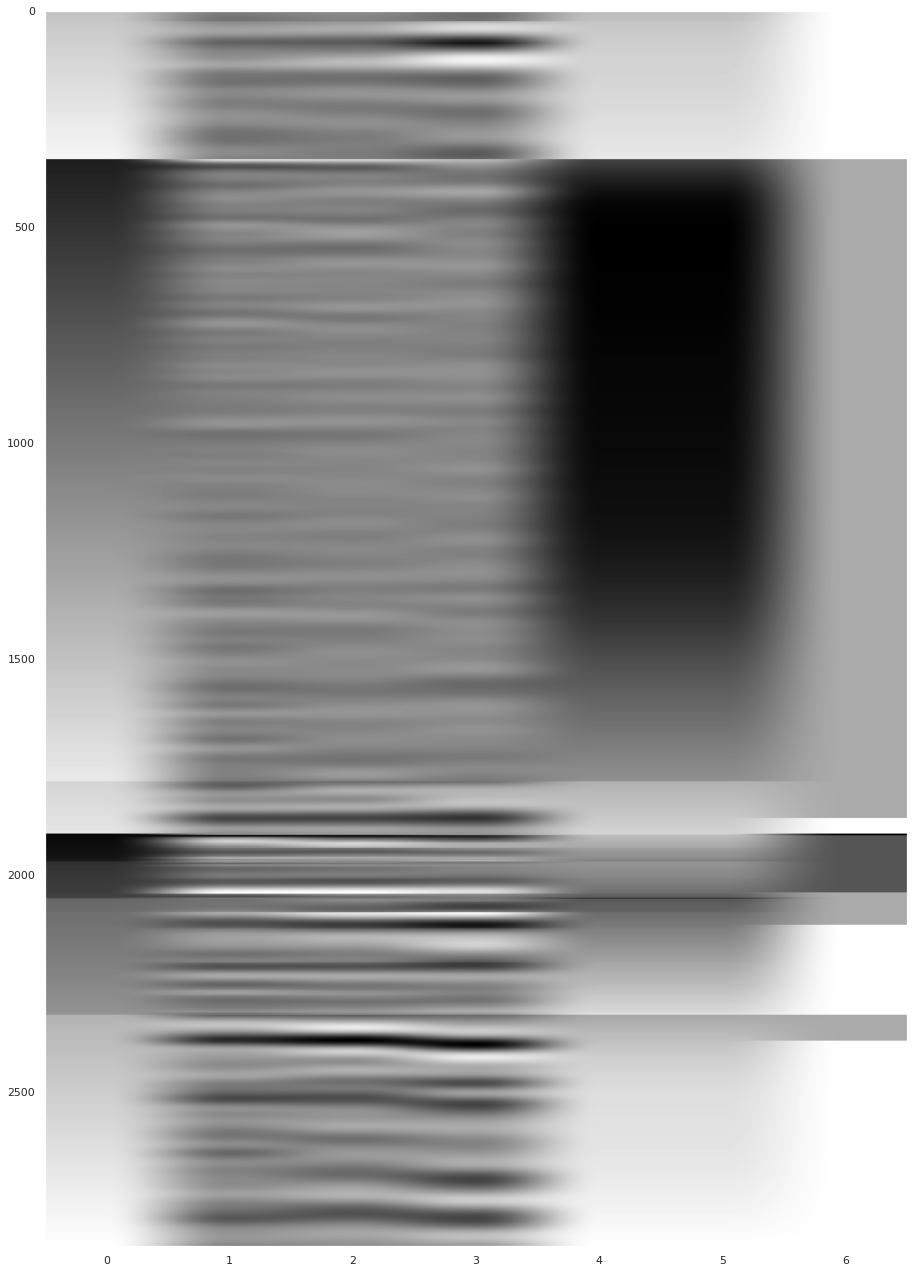

In [83]:
# plt.figure(figsize=(20,8))
# plt.subplot(311)
# plt.plot(X_train['twt'],y_train_1[['Zp']])
# plt.plot(X_train['twt'],y_train[['Zp']])
# plt.legend(loc='upper left', labels =['Zs_Prediction','Zp'])
# plt.xlabel('twt (ms) ')
# plt.ylabel('Zp')
# plt.subplot(312)
# plt.plot(X_train['twt'],y_train_1[['Zs']])
# plt.plot(X_train['twt'],y_train[['Zs']])
# plt.legend(loc='upper left', labels =['Zs_Prediction','Zs'])
# plt.xlabel('twt (ms) ')
# plt.ylabel('Zs')
# plt.subplot(313)
# plt.plot(X_train['twt'],y_train_1[['rhob']])
# plt.plot(X_train['twt'],y_train[['rhob']])
# plt.legend(loc='upper left', labels =['Rhob_Prediction','Rhob'])
# plt.xlabel('twt (ms) ')
# plt.ylabel('Rhob')
# plt.show();

In [882]:
# plt.figure(figsize=(20,8))
# plt.subplot(311)
# plt.plot(X_train['twt'],y_train_scaled1[['Zp']])
# # plt.plot(X_train['twt'],y_train[['Zp']])
# plt.legend(loc='upper left', labels =['Zs_Prediction','Zp'])
# plt.xlabel('twt (ms) ')
# plt.ylabel('Zp')
# plt.subplot(312)
# plt.plot(X_train['twt'],y_train_scaled1[['Zs']])
# # plt.plot(X_train['twt'],y_train[['Zs']])
# plt.legend(loc='upper left', labels =['Zs_Prediction','Zs'])
# plt.xlabel('twt (ms) ')
# plt.ylabel('Zs')
# plt.subplot(313)
# plt.plot(X_train['twt'],y_train_scaled1[['rhob']])
# # plt.plot(X_train['twt'],y_train[['rhob']])
# plt.legend(loc='upper left', labels =['Rhob_Prediction','Rhob'])
# plt.xlabel('twt (ms) ')
# plt.ylabel('Rhob')
# plt.show();

Now lets take a quick look at our scaled data, we should see values between -1 and 1. Each feature is scaled independent of the rest. Below is an example of what the training inputs look like now. 

# Section 3. Neural Network Model Training

Up to this point, the workflow should be the same regardless of the type of machine learning model you want to use. We will use a keras-tensorflow neural network approach for this part. 

Here we will design our neural network architecture. You can use this webapp to visualize various NN architectures: http://alexlenail.me/NN-SVG/index.html

The model below is a Sequential Model: A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Learn more about Sequential Models here: https://keras.io/guides/sequential_model/

**Architecture:**
- 8 input Neurons 
- 2 Hidden Layers w/ 32 neurons each 
- 3 Outputs 

**Hyperparameters:**
- Hidden Layer has ReLu Activation
- Output Layer has Linear Activation
- Adam Optimizer
- MSE as loss metric 
- EarlyStopping is active w/ Patience = 30 
- Batch Size is 256 
- 50% of data is reserved for validation 
- Training with a MAX of 5000 Epochs

In [883]:
# kernel_regularizer
# bias_regularizer
# activity_regularizer

In [884]:
X_train_scaledt  = np.expand_dims(X_train_scaled,axis=2)
X_test_scaledt  = np.expand_dims(X_test_scaled,axis=2)
y_train_scaled1t=y_train_scaled1.values
# X_train_scaledt.shape

In [1]:
# %%time
import time
from numpy.random import seed
import tensorflow as tf

# Train models and keep them in memory 
# This is where we define the amount of models in the ensemble
# We save those models to a list 'models'
#%%time
start = time.time()
regularizer= tf.keras.regularizers.L2(0.000000000000005)
regularizer1=tf.keras.regularizers.L2(0.001)
regularizer2=tf.keras.regularizers.L2(0.0002)
# regularizer2=tf.keras.regularizers.L2(0.000000000000005)
regularizer3=tf.keras.regularizers.L2(0.000000000000001)



initializer0 = tf.keras.initializers.Zeros()

# initializer = tf.keras.initializers.GlorotNormal(23)
initializer = tf.keras.initializers.GlorotNormal(33)
# regularizer = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)

n_members = 5
model_store = []

# We store our training performance in 'history_store'
history_store = []

#here we define model architecture and train the neural network in a loop for each model 
for i in range(n_members): 

    tf.random.set_seed(2)
    seed(2)
    model = Sequential()
    
#     model.add(layers.Dense(64, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_normal'))
#     model.add(layers.Dense(32, activation='sigmoid', kernel_initializer='glorot_normal'))
#     model.add(layers.Dense(16, activation='sigmoid', kernel_initializer='glorot_normal'))
#     model.add(layers.Dense(y_train_scaled1.shape[1], activation='tanh'))
 
    # Adding layers
    # Adding layers
    model.add(layers.Dense(128, activation='selu', input_dim=X_train_scaled.shape[1], 
                           kernel_initializer=initializer))
    model.add(layers.Dense(48, activation='sigmoid', kernel_initializer=initializer
                           ,kernel_regularizer=regularizer1))

    model.add(layers.Dense(48, activation='sigmoid', kernel_initializer=initializer))
    model.add(layers.Dense(48, activation='sigmoid', kernel_initializer=initializer))
    model.add(layers.Dense(32, activation='sigmoid', kernel_initializer=initializer))
    model.add(layers.Dense(32, activation='sigmoid', kernel_initializer=initializer))
    model.add(layers.Dense(32, activation='sigmoid', kernel_initializer=initializer))
    model.add(layers.Dense(16, activation='sigmoid', kernel_initializer=initializer))
    model.add(layers.Dense(16, activation='tanh', kernel_initializer=initializer))

    model.add(layers.Dense(8, activation='tanh', kernel_initializer=initializer
                          ,kernel_regularizer=regularizer2))

    model.add(layers.Dense(y_train_scaled1.shape[1], activation='tanh'))
    # Setting optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile model and add callbacks
    model.compile(optimizer=opt, loss='mse')
    callbacks = [k.callbacks.EarlyStopping(monitor='loss', patience=30)]
    
    # Fit and save! 
    history_store.append(model.fit(X_train_scaled, 
                                   y_train_scaled1, 
                                   epochs=2000, validation_split=0.1,
                                   shuffle=False, batch_size=256, callbacks=callbacks,
                                   verbose=0))
    model_store.append(model)
    # Some basic print statements for updating us during training
    loss = history_store[i].history['loss']
    epochs = range(len(loss))
    print('-------------------------------------------------- Completed Training of Model #', i)
    print('-------------------------------------------------- Total Epochs Range:', epochs )
    print('-----------------------------------------------------------------------------------')
end = time.time()
print(end - start)
yhats = [y_scaler.inverse_transform(model.predict(X_test_scaled)) for model in model_store]
yhats = np.array(yhats)
Zp_ensemble = yhats[:,:,0].mean(0)
Zs_ensemble = yhats[:,:,1].mean(0)
Rhob_ensemble = yhats[:,:,2].mean(0)
Results = y_test.copy()
Results['Zp_Prediction'] = Zp_ensemble
Results['Zs_Prediction'] = Zs_ensemble
Results['Rhob_Prediction'] = Rhob_ensemble
Results['twt'] = X_test['twt']
Results = Results.reset_index()
from sklearn.metrics import r2_score
p=r2_score(Results['Zp'], Results['Zp_Prediction'])
s=r2_score(Results['Zs'], Results['Zs_Prediction'])
d=r2_score(Results['rhob'], Results['Rhob_Prediction'])
print(p,s,d,p+s+d)

NameError: name 'Sequential' is not defined

In [ ]:
X_train_scaled

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(311)
plt.plot(Results['twt'],Results[['Zp_Prediction','Zp']])
plt.legend(loc='upper left', labels =['Zp_Prediction','Zp'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zp')
plt.subplot(312)
plt.plot(Results['twt'],Results[['Zs_Prediction','Zs']])
plt.legend(loc='upper left', labels =['Zs_Prediction','Zs'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zs')
plt.subplot(313)
plt.plot(Results['twt'],Results[['Rhob_Prediction','rhob']])
plt.legend(loc='upper left', labels =['Rhob_Prediction','Rhob'])
plt.xlabel('twt (ms) ')
plt.ylabel('Rhob')
plt.show();

Here we visualize the performance for each model starting with model #1. We want to interpret these and try to see how to adjust our model architecture and hyperparameters to improve the learning process. 

In [ ]:
# for history in history_store:
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(loss))
#     plt.figure(figsize=(25,5))
#     plt.plot(epochs, loss, 'r', label='Training loss')
#     plt.plot(epochs, val_loss, 'b', label='Validation loss')
#     plt.legend(loc='upper left')
#     plt.title(str(history))

# Section 4. Bootstrap Aggregation and Inference

**Bootstrap aggregation (bagging)** is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach.

Learn more about Ensembling NNs here: https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

In [ ]:
# yhats = [y_scaler.inverse_transform(model.predict(X_test_scaled)) for model in model_store]
# yhats = np.array(yhats)

In [ ]:
# Zp_ensemble = yhats[:,:,0].mean(0)
# Zs_ensemble = yhats[:,:,1].mean(0)
# Rhob_ensemble = yhats[:,:,2].mean(0)

In [ ]:
# Results = y_test.copy()
# Results['Zp_Prediction'] = Zp_ensemble
# Results['Zs_Prediction'] = Zs_ensemble
# Results['Rhob_Prediction'] = Rhob_ensemble
# Results['twt'] = X_test['twt']
# Results = Results.reset_index()
# # Results

In [ ]:
# from sklearn.metrics import r2_score
# p=r2_score(Results['Zp'], Results['Zp_Prediction'])
# s=r2_score(Results['Zs'], Results['Zs_Prediction'])
# d=r2_score(Results['rhob'], Results['Rhob_Prediction'])
# print(p,s,d,p+s+d)

In [ ]:
# plt.figure(figsize=(20,8))
# plt.subplot(311)
# plt.plot(Results['twt'],Results[['Zp_Prediction','Zp']])
# plt.legend(loc='upper left', labels =['Zp_Prediction','Zp'])
# plt.xlabel('twt (ms) ')
# plt.ylabel('Zp')
# plt.subplot(312)
# plt.plot(Results['twt'],Results[['Zs_Prediction','Zs']])
# plt.legend(loc='upper left', labels =['Zs_Prediction','Zs'])
# plt.xlabel('twt (ms) ')
# plt.ylabel('Zs')
# plt.subplot(313)
# plt.plot(Results['twt'],Results[['Rhob_Prediction','rhob']])
# plt.legend(loc='upper left', labels =['Rhob_Prediction','Rhob'])
# plt.xlabel('twt (ms) ')
# plt.ylabel('Rhob')
# plt.show();

# Conclusions

This scheme was only meant to give you a taste of what a basic workflow would look like. We recommend that you spend time researching methods to improve on these results. You didn't think we would give you the answer did you? However, this could help set the foundation if you are currently struggling to get started. 

**What did we do:** We used the work from a previous notebook to retrieve S3 seismic data using real-simple-seismic (rss) and extracting the traces along the wellbore of each well. We then used the data at the wellbore to do some basic feature engineering, build training and testing datatsets, prepare those datasets for a deep learning scheme, trained a vanilla NN model, and infered on blind (out of sample) data.

High Level Comments: 
- A neural networks may or may not be the best solution to this problem. You could try a different kind of machine learning algorithm. 
- We are definitely not doing any advanced feature engineering here. There is a ton of room for improvement here. 
- There is hardly any model optimization here. You could try using GridSearchCV to optimize hyperparameters. 
- We are not doing any input selection - there are various methods that could help with this suchas recursive input selection or stochastic removal of inputs
- Data augmentation - there is quite a problem with data sparsity in this dataset. We expect that teams that spend time on data augmentations are likely to see massive uplift in solution accuracy. 

# second

# Third Load in new well

In [905]:

import pickle
## read back well
file_name="well_sub_df.pikl"
file=open(file_name,"rb")
wells_3rd=pickle.load(file)
file.close()


## read back
file_name="well_sub_seismic.pikl"
file=open(file_name,"rb")
well_seismic_3rd=pickle.load(file)
file.close()

In [906]:
wells_3rd.loc['well_07']
# type(well_seismic_3rd)
# well_seismic_3rd['well_07']
# well_seismic_3rd

,inline,xline,rhob,p_impedance,s_impedance
twt,,,,,
2700.0,3256.5233,1389.3571,NaN,NaN,NaN
2700.5,3256.5234,1389.3559,NaN,NaN,NaN
2701.0,3256.5236,1389.3547,NaN,NaN,NaN
2701.5,3256.5237,1389.3535,NaN,NaN,NaN
2702.0,3256.5238,1389.3523,NaN,NaN,NaN
...,...,...,...,...,...
3347.5,3257.2388,1389.7321,NaN,NaN,NaN
3348.0,3257.2375,1389.7352,NaN,NaN,NaN
3354.5,3257.2122,1389.7759,NaN,NaN,NaN


In [907]:
near_07 = well_seismic_3rd['well_07']['near']
near_13 = well_seismic_3rd['well_13']['near']
mid_07 = well_seismic_3rd['well_07']['mid']
mid_13 = well_seismic_3rd['well_13']['mid']
far_07 = well_seismic_3rd['well_07']['far']
far_13 = well_seismic_3rd['well_13']['far']
vel_07 = well_seismic_3rd['well_07']['velocity']/0.3048
vel_13 = well_seismic_3rd['well_13']['velocity']/0.3048



near_07_composite = pd.DataFrame(np.mean((np.mean(near_07,axis=1)), axis=0), columns=['near_07_composite'])
near_13_composite = pd.DataFrame(np.mean((np.mean(near_13,axis=1)), axis=0), columns=['near_13_composite'])
mid_07_composite = pd.DataFrame(np.mean((np.mean(mid_07,axis=1)), axis=0), columns=['mid_07_composite'])
mid_13_composite = pd.DataFrame(np.mean((np.mean(mid_13,axis=1)), axis=0), columns=['mid_13_composite'])
far_07_composite = pd.DataFrame(np.mean((np.mean(far_07,axis=1)), axis=0), columns=['far_07_composite'])
far_13_composite = pd.DataFrame(np.mean((np.mean(far_13,axis=1)), axis=0), columns=['far_13_composite'])


vel_07_composite = pd.DataFrame(np.mean((np.mean(vel_07,axis=1)), axis=0), columns=['vel_07_composite'])
vel_13_composite = pd.DataFrame(np.mean((np.mean(vel_13,axis=1)), axis=0), columns=['vel_13_composite'])

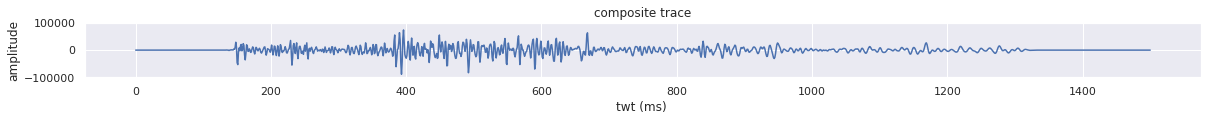

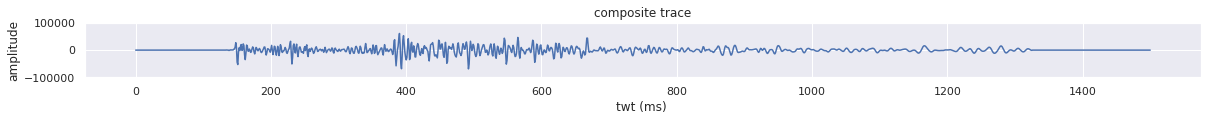

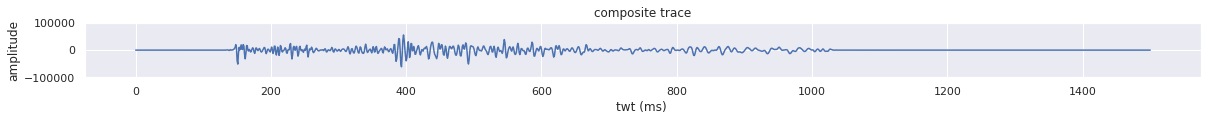

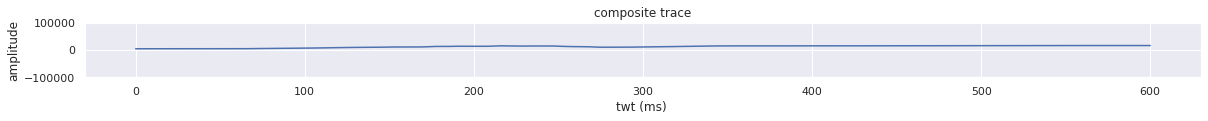

In [908]:
composite_07_data=[near_07_composite, mid_07_composite, far_07_composite, vel_07_composite ]
for composite in composite_07_data:
    plt.figure(figsize=(20,1))
    plt.plot(composite)
    plt.title('composite trace')
    plt.ylim(-100000,100000)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

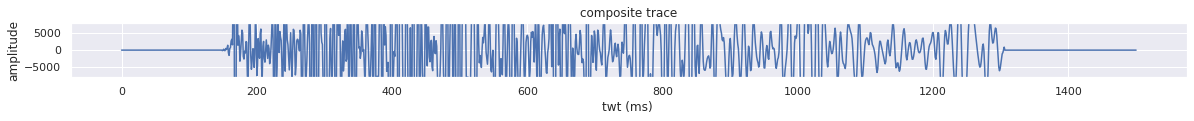

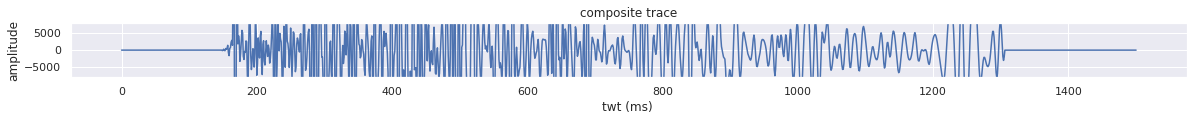

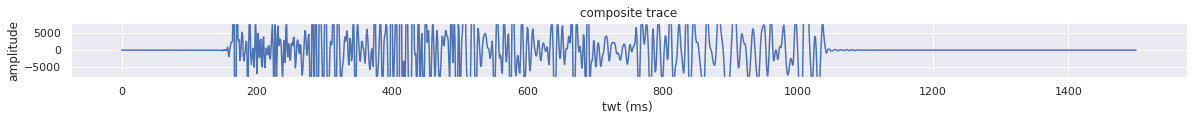

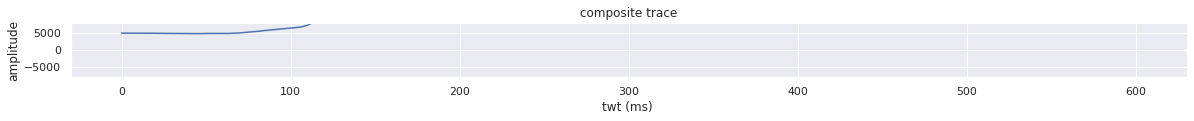

In [909]:
composite_13_data=[near_13_composite, mid_13_composite, far_13_composite,vel_13_composite ]
for composite in composite_13_data:
    plt.figure(figsize=(20,1))
    plt.plot(composite)
    plt.title('composite trace')
    plt.ylim(-8000,8000)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

In [910]:
# vel index at 10ms 
vel_twt = pd.DataFrame(np.arange(0, 6010.0, 10.0), columns=['twt'])

# index at .5 ms 
vel_resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])

In [911]:
# vel DataFrames to concatenate 
velconcat = [vel_twt, vel_07_composite, vel_13_composite]
tt_vel = pd.concat(velconcat, axis=1)

# Here we merge our vel to the resamp 'twt' array
vel_velconcat_resamp_raw = tt_vel.merge(vel_resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the vel after the resamp
vel_velconcat_resamp_interp = vel_velconcat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
vel_velconcat_resamp_interp
# type(vel_velconcat_resamp_interp)

,twt,vel_07_composite,vel_13_composite
0,0.0,4998.219403,4998.274439
1,0.5,4998.220261,4998.275376
2,1.0,4998.220987,4998.276169
3,1.5,4998.221588,4998.276825
4,2.0,4998.222071,4998.277352
...,...,...,...
11996,5998.0,16849.660140,17209.583299
11997,5998.5,16849.623489,17209.585539
11998,5999.0,16849.583678,17209.587491
11999,5999.5,16849.540611,17209.589133


In [912]:
# index at 4ms 
seismic_twt = pd.DataFrame(np.arange(0, 6004.0, 4.0), columns=['twt'])

# index at .5 ms 
resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])

In [913]:
# DataFrames to concatenate 
data_concat = [seismic_twt, near_07_composite, mid_07_composite, far_07_composite]
tt_seismic = pd.concat(data_concat, axis=1)

# Here we merge our seismic to the resamp 'twt' array
data_concat_resamp_raw = tt_seismic.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
data_concat_07_resamp_interp = data_concat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
data_concat_07_resamp_interp=data_concat_07_resamp_interp.set_index(['twt'])

In [914]:
data_concat_07_resamp_interp.head()

,near_07_composite,mid_07_composite,far_07_composite
twt,,,
0.0,-3.686249,-1.023616,-1.349676
0.5,-3.686249,-1.023616,-1.349676
1.0,-3.686249,-1.023616,-1.349676
1.5,-3.686249,-1.023616,-1.349676
2.0,-3.686249,-1.023616,-1.349676


In [915]:
ld_input_well_hor.head()

inline      xline  rhob  p_impedance  s_impedance  horizon
well_id twt                                                                  
well_07 2700.0  3256.5233  1389.3571   NaN          NaN          NaN      4.0
        2700.5  3256.5234  1389.3559   NaN          NaN          NaN      4.0
        2701.0  3256.5236  1389.3547   NaN          NaN          NaN      4.0
        2701.5  3256.5237  1389.3535   NaN          NaN          NaN      4.0
        2702.0  3256.5238  1389.3523   NaN          NaN          NaN      4.0

In [916]:
ld_07_well =ld_input_well_hor.loc[['well_07']]
ld_13_well =ld_input_well_hor.loc[['well_13']]
ld_07_well.head()

inline      xline  rhob  p_impedance  s_impedance  horizon
well_id twt                                                                  
well_07 2700.0  3256.5233  1389.3571   NaN          NaN          NaN      4.0
        2700.5  3256.5234  1389.3559   NaN          NaN          NaN      4.0
        2701.0  3256.5236  1389.3547   NaN          NaN          NaN      4.0
        2701.5  3256.5237  1389.3535   NaN          NaN          NaN      4.0
        2702.0  3256.5238  1389.3523   NaN          NaN          NaN      4.0

In [917]:
ld_07_hor=ld_07_well.drop(columns=['inline','xline',
                               'rhob','p_impedance','s_impedance'])

ld_13_hor=ld_13_well.drop(columns=['inline','xline',
                               'rhob','p_impedance','s_impedance'])
ld_07_hor=ld_07_hor.reset_index().rename(columns={'well_id':'well_name'})
ld_13_hor=ld_13_hor.reset_index().rename(columns={'well_id':'well_name'})
ld_07_hor.head()

,well_name,twt,horizon
0,well_07,2700.0,4.0
1,well_07,2700.5,4.0
2,well_07,2701.0,4.0
3,well_07,2701.5,4.0
4,well_07,2702.0,4.0


# Well 07

In [918]:
tmax_07=wells_3rd.loc['well_07'].reset_index()['twt'].max()
tmin_07=wells_3rd.loc['well_07'].reset_index()['twt'].min()
print(tmax_07,tmin_07)

3355.5 2700.0


In [919]:
data_concat_07_resamp_interp['vel_07_composite']=vel_velconcat_resamp_interp['vel_07_composite'].to_numpy()
data_concat_07_resamp_interp

,near_07_composite,mid_07_composite,far_07_composite,vel_07_composite
twt,,,,
0.0,-3.686249,-1.023616,-1.349676,4998.219403
0.5,-3.686249,-1.023616,-1.349676,4998.220261
1.0,-3.686249,-1.023616,-1.349676,4998.220987
1.5,-3.686249,-1.023616,-1.349676,4998.221588
2.0,-3.686249,-1.023616,-1.349676,4998.222071
...,...,...,...,...
5998.0,-3.686249,-1.023616,-1.349676,16849.660140
5998.5,-3.686249,-1.023616,-1.349676,16849.623489
5999.0,-3.686249,-1.023616,-1.349676,16849.583678


In [920]:
data_concat_07_resamp_interp.rename(columns={"near_07_composite": "near_trace","mid_07_composite": "mid_trace",
                           "far_07_composite": "far_trace","vel_07_composite": "vel_trace"}, inplace=True)
data_concat_07_resamp_interp['vels_trace']=data_concat_07_resamp_interp['vel_trace']/1.44
data_concat_07_resamp_interp

,near_trace,mid_trace,far_trace,vel_trace,vels_trace
twt,,,,,
0.0,-3.686249,-1.023616,-1.349676,4998.219403,3470.985697
0.5,-3.686249,-1.023616,-1.349676,4998.220261,3470.986293
1.0,-3.686249,-1.023616,-1.349676,4998.220987,3470.986797
1.5,-3.686249,-1.023616,-1.349676,4998.221588,3470.987214
2.0,-3.686249,-1.023616,-1.349676,4998.222071,3470.987550
...,...,...,...,...,...
5998.0,-3.686249,-1.023616,-1.349676,16849.660140,11701.152875
5998.5,-3.686249,-1.023616,-1.349676,16849.623489,11701.127423
5999.0,-3.686249,-1.023616,-1.349676,16849.583678,11701.099777


In [921]:
data_concat_07_resamp_interp.head()

,near_trace,mid_trace,far_trace,vel_trace,vels_trace
twt,,,,,
0.0,-3.686249,-1.023616,-1.349676,4998.219403,3470.985697
0.5,-3.686249,-1.023616,-1.349676,4998.220261,3470.986293
1.0,-3.686249,-1.023616,-1.349676,4998.220987,3470.986797
1.5,-3.686249,-1.023616,-1.349676,4998.221588,3470.987214
2.0,-3.686249,-1.023616,-1.349676,4998.222071,3470.987550


In [922]:
data07=data_concat_07_resamp_interp.copy()
data07 = data07.reset_index().merge(ld_07_hor, how='right', on=['twt'])
data07 =data07.drop(columns=['well_name']).set_index(['twt'])
data07




,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
twt,,,,,,
2700.0,-19414.808873,-6953.786711,-5259.227757,11674.186614,8107.074037,4.0
2700.5,-18586.024117,-6778.277874,-5377.743283,11658.879050,8096.443785,4.0
2701.0,-17461.104610,-6539.121132,-5440.578328,11643.659452,8085.874620,4.0
2701.5,-16071.273089,-6241.883317,-5449.480381,11628.529754,8075.367885,4.0
2702.0,-14447.752293,-5892.131262,-5406.196934,11613.491888,8064.924922,4.0
...,...,...,...,...,...,...
3347.5,-13405.705716,-5423.546161,-3340.350845,14789.720806,10270.639449,5.0
3348.0,-10379.789654,-4566.079368,-2919.253311,14794.326289,10273.837701,5.0
3354.5,30289.104534,10459.122943,5008.760149,14853.032446,10314.605865,5.0


In [923]:
X_07=data07.loc[2700:3355.5].reset_index()

In [924]:
X_07

,twt,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
0,2700.0,-19414.808873,-6953.786711,-5259.227757,11674.186614,8107.074037,4.0
1,2700.5,-18586.024117,-6778.277874,-5377.743283,11658.879050,8096.443785,4.0
2,2701.0,-17461.104610,-6539.121132,-5440.578328,11643.659452,8085.874620,4.0
3,2701.5,-16071.273089,-6241.883317,-5449.480381,11628.529754,8075.367885,4.0
4,2702.0,-14447.752293,-5892.131262,-5406.196934,11613.491888,8064.924922,4.0
...,...,...,...,...,...,...,...
1247,3347.5,-13405.705716,-5423.546161,-3340.350845,14789.720806,10270.639449,5.0
1248,3348.0,-10379.789654,-4566.079368,-2919.253311,14794.326289,10273.837701,5.0
1249,3354.5,30289.104534,10459.122943,5008.760149,14853.032446,10314.605865,5.0
1250,3355.0,31634.210776,11322.783869,5678.057844,14857.458901,10317.679792,5.0


In [925]:
X_input_scaled_07 = X_scaler.transform(X_07)
X_input_scaled_07=pd.DataFrame(X_input_scaled_07,columns=X_07.columns)
X_input_scaled_07['well_name']='well_07'
X_input_scaled_07=X_input_scaled_07.set_index('well_name')
X_input_scaled_07

,twt,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
well_name,,,,,,,
well_07,-0.487493,-0.257512,-0.059922,-0.070484,-0.543154,-0.543154,0.333333
well_07,-0.486381,-0.245990,-0.057148,-0.073297,-0.549402,-0.549402,0.333333
well_07,-0.485270,-0.230351,-0.053368,-0.074788,-0.555615,-0.555615,0.333333
well_07,-0.484158,-0.211029,-0.048670,-0.075000,-0.561790,-0.561790,0.333333
well_07,-0.483046,-0.188458,-0.043142,-0.073972,-0.567929,-0.567929,0.333333
...,...,...,...,...,...,...,...
well_07,0.952196,-0.173971,-0.035736,-0.024932,0.728538,0.728538,1.000000
well_07,0.953307,-0.131904,-0.022183,-0.014936,0.730418,0.730418,1.000000
well_07,0.967760,0.433494,0.215295,0.173262,0.754381,0.754381,1.000000


In [926]:
yhats_07 = [y_scaler.inverse_transform(model.predict(X_input_scaled_07)) for model in model_store]
yhats_07 = np.array(yhats_07)

In [927]:
Zp_ensemble= yhats_07[:,:,0].mean(0)
Zs_ensemble = yhats_07[:,:,1].mean(0)
Rhob_ensemble = yhats_07[:,:,2].mean(0)

In [928]:
Results0 = X_07.copy()

Results0['Zp_Prediction'] = Zp_ensemble
Results0['Zs_Prediction'] = Zs_ensemble
Results0['Rhob_Prediction'] = Rhob_ensemble
Results0= Results0.drop(['near_trace','mid_trace', 'far_trace','vel_trace','vels_trace','horizon'], axis=1)
# Results0 = Results0.reset_index()
Results0

,twt,Zp_Prediction,Zs_Prediction,Rhob_Prediction
0,2700.0,27509.371094,13942.973633,2.491609
1,2700.5,27491.125000,13928.939453,2.491264
2,2701.0,27482.300781,13922.153320,2.491097
3,2701.5,27481.712891,13921.703125,2.491086
4,2702.0,27488.500000,13926.927734,2.491215
...,...,...,...,...
1247,3347.5,38426.183594,22011.183594,2.605239
1248,3348.0,38416.773438,22004.191406,2.605171
1249,3354.5,38183.558594,21831.298828,2.603487
1250,3355.0,38159.386719,21813.419922,2.603313


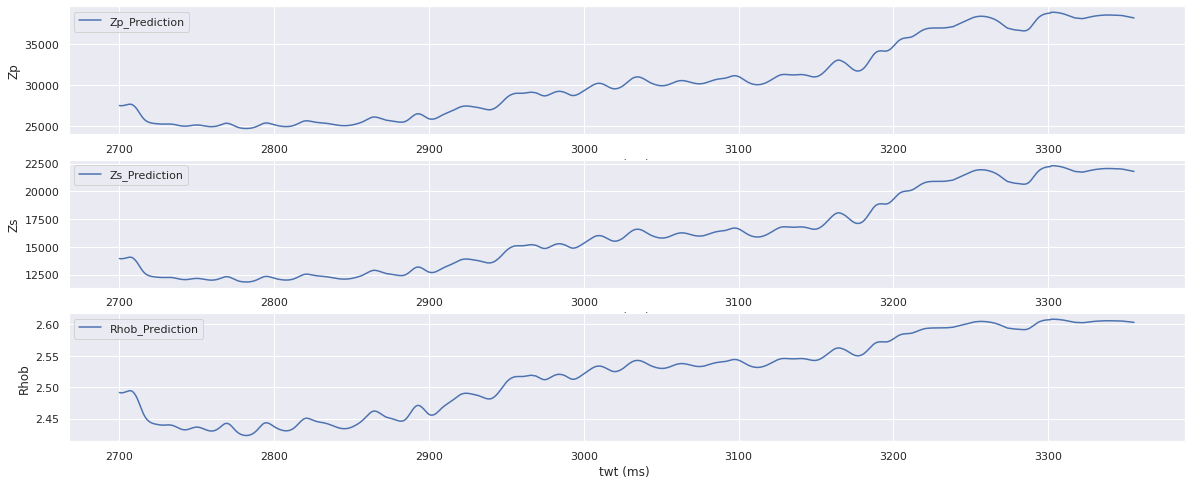

In [929]:
plt.figure(figsize=(20,8))
plt.subplot(311)
plt.plot(Results0['twt'],Results0[['Zp_Prediction']])
plt.legend(loc='upper left', labels =['Zp_Prediction'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zp')
plt.subplot(312)
plt.plot(Results0['twt'],Results0[['Zs_Prediction']])
plt.legend(loc='upper left', labels =['Zs_Prediction'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zs')
plt.subplot(313)
plt.plot(Results0['twt'],Results0[['Rhob_Prediction']])
plt.legend(loc='upper left', labels =['Rhob_Prediction'])
plt.xlabel('twt (ms) ')
plt.ylabel('Rhob')
plt.show();

# Well 13

In [930]:
# DataFrames to concatenate 
data_concat = [seismic_twt, near_13_composite, mid_13_composite, far_13_composite]
tt_seismic = pd.concat(data_concat, axis=1)

# Here we merge our seismic to the resamp 'twt' array
data_concat_resamp_raw = tt_seismic.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
data_concat_13_resamp_interp = data_concat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
data_concat_13_resamp_interp=data_concat_13_resamp_interp.set_index(['twt'])
data_concat_13_resamp_interp

,near_13_composite,mid_13_composite,far_13_composite
twt,,,
0.0,-1.837291,-1.353598,-1.478535
0.5,-1.837291,-1.353598,-1.478535
1.0,-1.837291,-1.353598,-1.478535
1.5,-1.837291,-1.353598,-1.478535
2.0,-1.837291,-1.353598,-1.478535
...,...,...,...
5998.0,-1.837291,-1.353598,-1.478535
5998.5,-1.837291,-1.353598,-1.478535
5999.0,-1.837291,-1.353598,-1.478535


In [931]:
data_concat_13_resamp_interp['vel_13_composite']=vel_velconcat_resamp_interp['vel_13_composite'].to_numpy()

data_concat_13_resamp_interp

,near_13_composite,mid_13_composite,far_13_composite,vel_13_composite
twt,,,,
0.0,-1.837291,-1.353598,-1.478535,4998.274439
0.5,-1.837291,-1.353598,-1.478535,4998.275376
1.0,-1.837291,-1.353598,-1.478535,4998.276169
1.5,-1.837291,-1.353598,-1.478535,4998.276825
2.0,-1.837291,-1.353598,-1.478535,4998.277352
...,...,...,...,...
5998.0,-1.837291,-1.353598,-1.478535,17209.583299
5998.5,-1.837291,-1.353598,-1.478535,17209.585539
5999.0,-1.837291,-1.353598,-1.478535,17209.587491


In [932]:
data_concat_13_resamp_interp.rename(columns={"near_13_composite": "near_trace","mid_13_composite": "mid_trace",
                           "far_13_composite": "far_trace","vel_13_composite": "vel_trace"}, inplace=True)
data_concat_13_resamp_interp['vels_trace']=data_concat_13_resamp_interp['vel_trace']/1.44

data_concat_13_resamp_interp

,near_trace,mid_trace,far_trace,vel_trace,vels_trace
twt,,,,,
0.0,-1.837291,-1.353598,-1.478535,4998.274439,3471.023916
0.5,-1.837291,-1.353598,-1.478535,4998.275376,3471.024567
1.0,-1.837291,-1.353598,-1.478535,4998.276169,3471.025117
1.5,-1.837291,-1.353598,-1.478535,4998.276825,3471.025573
2.0,-1.837291,-1.353598,-1.478535,4998.277352,3471.025939
...,...,...,...,...,...
5998.0,-1.837291,-1.353598,-1.478535,17209.583299,11951.099513
5998.5,-1.837291,-1.353598,-1.478535,17209.585539,11951.101069
5999.0,-1.837291,-1.353598,-1.478535,17209.587491,11951.102424


In [933]:
tmax_13=wells_3rd.loc['well_13'].reset_index()['twt'].max()
tmin_13=wells_3rd.loc['well_13'].reset_index()['twt'].min()
print(tmax_13,tmin_13)

3385.5 3125.5


In [934]:
data13=data_concat_13_resamp_interp.copy()
data13 = data13.reset_index().merge(ld_13_hor, how='right', on=['twt'])
data13 =data13.drop(columns=['well_name']).set_index(['twt'])
data13

,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
twt,,,,,,
3125.5,-10887.482116,-14114.008933,-15500.837619,13553.598450,9412.221146,5.0
3126.0,-9714.936237,-13972.036874,-15983.962110,13562.573769,9418.454006,5.0
3126.5,-8709.905184,-13811.998763,-16379.228619,13571.571266,9424.702268,5.0
3127.0,-7900.016806,-13636.339673,-16678.690051,13580.591245,9430.966142,5.0
3127.5,-7312.898950,-13447.504677,-16874.399309,13589.634010,9437.245840,5.0
...,...,...,...,...,...,...
3383.5,26733.867416,14958.462952,10208.495357,15788.782215,10964.432094,5.0
3384.0,25289.584472,14376.585753,10203.257826,15792.143807,10966.766533,5.0
3384.5,23634.852576,13716.122970,10158.860149,15795.484189,10969.086243,5.0


In [935]:
X_13=data13.loc[tmin_13:tmax_13].reset_index()

In [936]:
X_13

,twt,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
0,3125.5,-10887.482116,-14114.008933,-15500.837619,13553.598450,9412.221146,5.0
1,3126.0,-9714.936237,-13972.036874,-15983.962110,13562.573769,9418.454006,5.0
2,3126.5,-8709.905184,-13811.998763,-16379.228619,13571.571266,9424.702268,5.0
3,3127.0,-7900.016806,-13636.339673,-16678.690051,13580.591245,9430.966142,5.0
4,3127.5,-7312.898950,-13447.504677,-16874.399309,13589.634010,9437.245840,5.0
...,...,...,...,...,...,...,...
516,3383.5,26733.867416,14958.462952,10208.495357,15788.782215,10964.432094,5.0
517,3384.0,25289.584472,14376.585753,10203.257826,15792.143807,10966.766533,5.0
518,3384.5,23634.852576,13716.122970,10158.860149,15795.484189,10969.086243,5.0
519,3385.0,21801.524090,12989.140278,10077.049315,15798.805538,10971.392735,5.0


In [937]:
X_input_scaled_13 =X_scaler.transform(X_13)
X_input_scaled_13=pd.DataFrame(X_input_scaled_13,columns=X_13.columns)
X_input_scaled_13['well_name']='well_13'
X_input_scaled_13=X_input_scaled_13.set_index('well_name')
X_input_scaled_13

,twt,near_trace,mid_trace,far_trace,vel_trace,vels_trace,horizon
well_name,,,,,,,
well_13,0.458588,-0.138962,-0.173092,-0.313603,0.223980,0.223980,1.0
well_13,0.459700,-0.122660,-0.170848,-0.325072,0.227644,0.227644,1.0
well_13,0.460812,-0.108688,-0.168318,-0.334455,0.231316,0.231316,1.0
well_13,0.461923,-0.097429,-0.165542,-0.341563,0.234998,0.234998,1.0
well_13,0.463035,-0.089266,-0.162557,-0.346209,0.238689,0.238689,1.0
...,...,...,...,...,...,...,...
well_13,1.032240,0.384067,0.286409,0.296696,1.136333,1.136333,1.0
well_13,1.033352,0.363988,0.277212,0.296571,1.137705,1.137705,1.0
well_13,1.034464,0.340984,0.266773,0.295517,1.139069,1.139069,1.0


In [938]:
yhats_13 = [y_scaler.inverse_transform(model.predict(X_input_scaled_13)) for model in model_store]
yhats_13 = np.array(yhats_13)

In [939]:
Zp_ensemble= yhats_13[:,:,0].mean(0)
Zs_ensemble = yhats_13[:,:,1].mean(0)
Rhob_ensemble = yhats_13[:,:,2].mean(0)

In [940]:
Results2 = X_13.copy()

Results2['Zp_Prediction'] = Zp_ensemble
Results2['Zs_Prediction'] = Zs_ensemble
Results2['Rhob_Prediction'] = Rhob_ensemble
Results2= Results2.drop(['near_trace','mid_trace', 'far_trace','vel_trace','vels_trace','horizon'], axis=1)
# Results2 = Results2.reset_index()
Results2

,twt,Zp_Prediction,Zs_Prediction,Rhob_Prediction
0,3125.5,38651.957031,22179.701172,2.606878
1,3126.0,38678.531250,22199.625000,2.607072
2,3126.5,38699.863281,22215.628906,2.607227
3,3127.0,38716.457031,22228.089844,2.607348
4,3127.5,38728.679688,22237.275391,2.607437
...,...,...,...,...
516,3383.5,37088.101562,21025.431641,2.595477
517,3384.0,37092.808594,21028.867188,2.595512
518,3384.5,37101.246094,21035.037109,2.595575
519,3385.0,37112.769531,21043.464844,2.595661


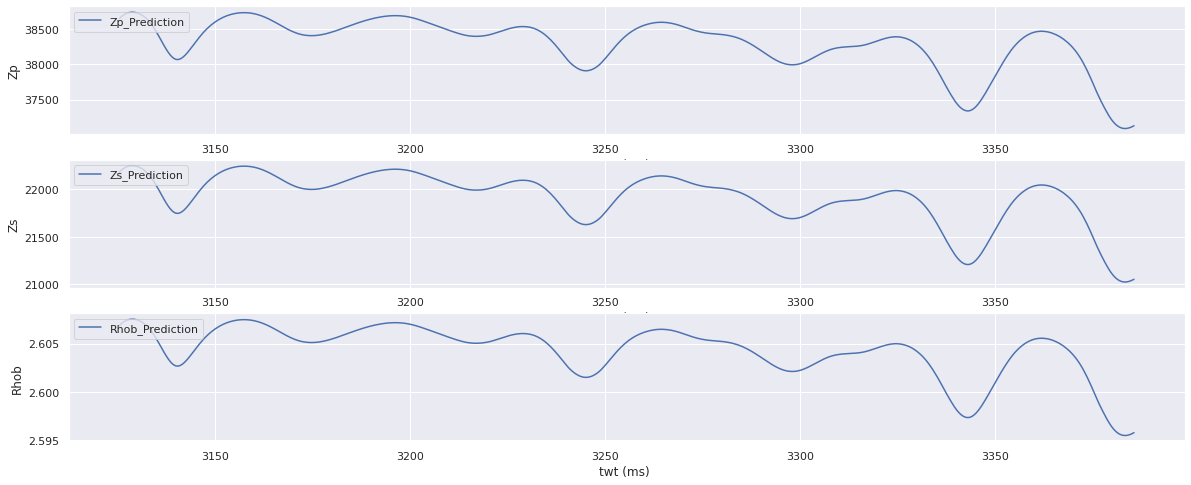

In [941]:
plt.figure(figsize=(20,8))
plt.subplot(311)
plt.plot(Results2['twt'],Results2[['Zp_Prediction']])
plt.legend(loc='upper left', labels =['Zp_Prediction'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zp')
plt.subplot(312)
plt.plot(Results2['twt'],Results2[['Zs_Prediction']])
plt.legend(loc='upper left', labels =['Zs_Prediction'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zs')
plt.subplot(313)
plt.plot(Results2['twt'],Results2[['Rhob_Prediction']])
plt.legend(loc='upper left', labels =['Rhob_Prediction'])
plt.xlabel('twt (ms) ')
plt.ylabel('Rhob')
plt.show();

# Match with assigned data

In [942]:
filename1='TeamCowboy_Intermediate03_Results_20210423.json'
cw=pd.read_json(filename1)
cw = cw.reset_index()
cw

,index,well_id,twt,inline,xline,rhob,p_impedance,s_impedance
0,0,well_07,2700.0,3256.5233,1389.3571,2.4349,25095.9531,12515.1709
1,1,well_07,2700.5,3256.5234,1389.3559,2.4272,25032.0977,12466.0547
2,2,well_07,2701.0,3256.5236,1389.3547,2.4202,24966.0703,12425.3145
3,3,well_07,2701.5,3256.5237,1389.3535,2.4127,24919.6934,12377.0400
4,4,well_07,2702.0,3256.5238,1389.3523,2.4043,24869.9492,12331.7637
...,...,...,...,...,...,...,...,...
1768,1768,well_13,3383.5,2407.1952,2675.8771,2.6326,41378.8984,24373.8281
1769,1769,well_13,3384.0,2407.1905,2675.8925,2.6316,41275.9922,24237.2344
1770,1770,well_13,3384.5,2407.1858,2675.9078,2.6312,41206.0547,24142.7285
1771,1771,well_13,3385.0,2407.1811,2675.9232,2.6299,41089.1523,24080.9355


In [944]:
filename1='7seas_Intermediate02_Results_20210422.json'
ld=pd.read_json(filename1)
ld = ld.reset_index()
ld

,index,well_id,twt,inline,xline,rhob,p_impedance,s_impedance
0,0,well_07,2700.0,3256.5233,1389.3571,2.3656,23377.8672,11529.7080
1,1,well_07,2700.5,3256.5234,1389.3559,2.3738,23467.5449,11541.3760
2,2,well_07,2701.0,3256.5236,1389.3547,2.3833,23575.1836,11557.2520
3,3,well_07,2701.5,3256.5237,1389.3535,2.3936,23694.7207,11576.5352
4,4,well_07,2702.0,3256.5238,1389.3523,2.4049,23824.4863,11596.6328
...,...,...,...,...,...,...,...,...
1768,1768,well_13,3383.5,2407.1952,2675.8771,2.5821,36405.0547,21591.9863
1769,1769,well_13,3384.0,2407.1905,2675.8925,2.5832,36421.8047,21593.7129
1770,1770,well_13,3384.5,2407.1858,2675.9078,2.5843,36439.5273,21595.6289
1771,1771,well_13,3385.0,2407.1811,2675.9232,2.5851,36461.6016,21606.3867


# direct models

In [945]:
Results2['well_id'] = 'well_13'
Results0['well_id'] = 'well_07'

In [946]:
result_07=Results0
result_13=Results2
# result_07=Results0.set_index(['well_id','twt'])
# result_13=Results2.set_index(['well_id','twt'])

In [947]:
wells_3rd
w3rd_07=wells_3rd.loc['well_07'].reset_index()
w3rd_13=wells_3rd.loc['well_13'].reset_index()

In [948]:
w3rd_07

,twt,inline,xline,rhob,p_impedance,s_impedance
0,2700.0,3256.5233,1389.3571,NaN,NaN,NaN
1,2700.5,3256.5234,1389.3559,NaN,NaN,NaN
2,2701.0,3256.5236,1389.3547,NaN,NaN,NaN
3,2701.5,3256.5237,1389.3535,NaN,NaN,NaN
4,2702.0,3256.5238,1389.3523,NaN,NaN,NaN
...,...,...,...,...,...,...
1247,3347.5,3257.2388,1389.7321,NaN,NaN,NaN
1248,3348.0,3257.2375,1389.7352,NaN,NaN,NaN
1249,3354.5,3257.2122,1389.7759,NaN,NaN,NaN
1250,3355.0,3257.2097,1389.7788,NaN,NaN,NaN


In [949]:
result_07
r07=result_07[result_07.twt.isin(w3rd_07.twt)]
print(r07)
r13=result_13[result_13.twt.isin(w3rd_13.twt)]
print(r13)
# r13=r13.drop(['index'],axis=1)

         twt  Zp_Prediction  Zs_Prediction  Rhob_Prediction  well_id
0     2700.0   27509.371094   13942.973633         2.491609  well_07
1     2700.5   27491.125000   13928.939453         2.491264  well_07
2     2701.0   27482.300781   13922.153320         2.491097  well_07
3     2701.5   27481.712891   13921.703125         2.491086  well_07
4     2702.0   27488.500000   13926.927734         2.491215  well_07
...      ...            ...            ...              ...      ...
1247  3347.5   38426.183594   22011.183594         2.605239  well_07
1248  3348.0   38416.773438   22004.191406         2.605171  well_07
1249  3354.5   38183.558594   21831.298828         2.603487  well_07
1250  3355.0   38159.386719   21813.419922         2.603313  well_07
1251  3355.5   38135.437500   21795.712891         2.603140  well_07

[1252 rows x 5 columns]
        twt  Zp_Prediction  Zs_Prediction  Rhob_Prediction  well_id
0    3125.5   38651.957031   22179.701172         2.606878  well_13
1    3126.0

In [950]:
resulty=pd.concat([r07,r13],axis=0).reset_index()
# resulty=result.set_index(['well_id','twt'])
# resulty=resulty.drop(columns=['index','vels_trace','horizon'])
resulty

,index,twt,Zp_Prediction,Zs_Prediction,Rhob_Prediction,well_id
0,0,2700.0,27509.371094,13942.973633,2.491609,well_07
1,1,2700.5,27491.125000,13928.939453,2.491264,well_07
2,2,2701.0,27482.300781,13922.153320,2.491097,well_07
3,3,2701.5,27481.712891,13921.703125,2.491086,well_07
4,4,2702.0,27488.500000,13926.927734,2.491215,well_07
...,...,...,...,...,...,...
1768,516,3383.5,37088.101562,21025.431641,2.595477,well_13
1769,517,3384.0,37092.808594,21028.867188,2.595512,well_13
1770,518,3384.5,37101.246094,21035.037109,2.595575,well_13
1771,519,3385.0,37112.769531,21043.464844,2.595661,well_13


In [951]:
resulty=resulty.rename(columns={"Zp_Prediction": "p_impedance","Zs_Prediction": "s_impedance","Rhob_Prediction":"rhob"})

In [952]:
resulty=resulty.drop(columns=['index'])
resulty

,twt,p_impedance,s_impedance,rhob,well_id
0,2700.0,27509.371094,13942.973633,2.491609,well_07
1,2700.5,27491.125000,13928.939453,2.491264,well_07
2,2701.0,27482.300781,13922.153320,2.491097,well_07
3,2701.5,27481.712891,13921.703125,2.491086,well_07
4,2702.0,27488.500000,13926.927734,2.491215,well_07
...,...,...,...,...,...
1768,3383.5,37088.101562,21025.431641,2.595477,well_13
1769,3384.0,37092.808594,21028.867188,2.595512,well_13
1770,3384.5,37101.246094,21035.037109,2.595575,well_13
1771,3385.0,37112.769531,21043.464844,2.595661,well_13


In [953]:
cols = list(resulty.columns)
a,b,c,d=cols.index('p_impedance'),cols.index('s_impedance'),cols.index('rhob'),cols.index('well_id')
cols[a],cols[b],cols[c],cols[d]=cols[d],cols[c],cols[a],cols[b]
resulty=resulty[cols]
resulty

,twt,well_id,rhob,p_impedance,s_impedance
0,2700.0,well_07,2.491609,27509.371094,13942.973633
1,2700.5,well_07,2.491264,27491.125000,13928.939453
2,2701.0,well_07,2.491097,27482.300781,13922.153320
3,2701.5,well_07,2.491086,27481.712891,13921.703125
4,2702.0,well_07,2.491215,27488.500000,13926.927734
...,...,...,...,...,...
1768,3383.5,well_13,2.595477,37088.101562,21025.431641
1769,3384.0,well_13,2.595512,37092.808594,21028.867188
1770,3384.5,well_13,2.595575,37101.246094,21035.037109
1771,3385.0,well_13,2.595661,37112.769531,21043.464844


In [958]:
filename='7seas_Intermediate09_Results_20210426.json'

resulty.to_json(filename,
               double_precision=4,

)


In [961]:
r1=resulty

filename='7seas_Intermediate08_Results_20210426.json'
r=pd.read_json(filename)
r = r.reset_index()
r

,index,twt,well_id,rhob,p_impedance,s_impedance
0,0,2700.0,well_07,2.4910,27442.8125,13866.8633
1,1,2700.5,well_07,2.4907,27424.7598,13853.0967
2,2,2701.0,well_07,2.4905,27416.3281,13846.6729
3,3,2701.5,well_07,2.4905,27416.2148,13846.5869
4,4,2702.0,well_07,2.4906,27423.5859,13852.2139
...,...,...,...,...,...,...
1768,1768,3383.5,well_13,2.5979,37326.4922,21189.0742
1769,1769,3384.0,well_13,2.5979,37329.0273,21190.9492
1770,1770,3384.5,well_13,2.5980,37334.5586,21195.0332
1771,1771,3385.0,well_13,2.5980,37342.5938,21200.9688


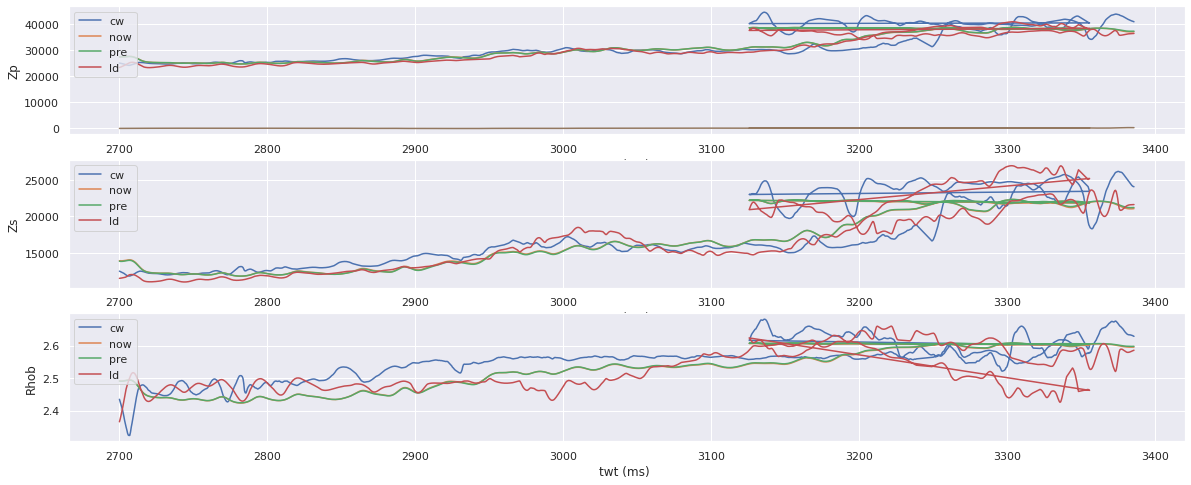

In [962]:
plt.figure(figsize=(20,8))

plt.subplot(311)
plt.plot(cw['twt'],cw[['p_impedance']])
plt.plot(cw['twt'],r1[['p_impedance']])
plt.plot(cw['twt'],r[['p_impedance']])
plt.plot(r['twt'],ld[['p_impedance']])
plt.plot(cw['twt'],r-r1[['p_impedance']])
plt.legend(loc='upper left', labels =['cw','now','pre','ld'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zp')
plt.subplot(312)
plt.plot(cw['twt'],cw[['s_impedance']])
plt.plot(cw['twt'],r1[['s_impedance']])
plt.plot(cw['twt'],r[['s_impedance']])
plt.plot(r['twt'],ld[['s_impedance']])
plt.legend(loc='upper left', labels =['cw','now','pre','ld'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zs')
plt.subplot(313)
plt.plot(cw['twt'],cw[['rhob']])
plt.plot(cw['twt'],r1[['rhob']])
plt.plot(cw['twt'],r[['rhob']])
plt.plot(r['twt'],ld[['rhob']])
plt.legend(loc='upper left', labels =['cw','now','pre','ld'])
plt.xlabel('twt (ms) ')
plt.ylabel('Rhob')
plt.show();

In [969]:
min(r['p_impedance']-r1['p_impedance'])



-109.18163125000137

,twt,well_id,rhob,p_impedance,s_impedance
0,2700.0,well_07,2.491609,27509.371094,13942.973633
1,2700.5,well_07,2.491264,27491.125000,13928.939453
2,2701.0,well_07,2.491097,27482.300781,13922.153320
3,2701.5,well_07,2.491086,27481.712891,13921.703125
4,2702.0,well_07,2.491215,27488.500000,13926.927734
...,...,...,...,...,...
1768,3383.5,well_13,2.595477,37088.101562,21025.431641
1769,3384.0,well_13,2.595512,37092.808594,21028.867188
1770,3384.5,well_13,2.595575,37101.246094,21035.037109
1771,3385.0,well_13,2.595661,37112.769531,21043.464844
